## Install required packages

In [ ]:
!pip install --upgrade pip
!pip install -U "transformers>=4.39.0" "datasets>=2.18" "evaluate>=0.4"
!pip install -U "accelerate>=0.26.0" "bitsandbytes"
!pip install -U tensorboard

!pip install transformers-interpret

!pip install scikit-learn matplotlib seaborn optuna
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

## Import necessary libraries

In [39]:
# =====================================
# Imports for Hebrew Idiom Classifier Project
# =====================================

# Data handling
import os, shutil, json
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pandas as pd
import numpy as np
from pathlib import Path
import re
from datasets import Dataset, DatasetDict
import datasets
import optuna
import transformers, inspect, importlib, sys, accelerate
from scipy.stats import binomtest

# PyTorch & HuggingFace Transformers
import torch, gc
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    IntervalStrategy,
    EarlyStoppingCallback,
    AutoModel,
)
import evaluate  # HuggingFace's metrics hub
from transformers_interpret import SequenceClassificationExplainer

# Stats
try:
    from statsmodels.stats.contingency_tables import mcnemar
    HAVE_STATSMODELS = True
except Exception:
    HAVE_STATSMODELS = False

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    precision_recall_curve,
    roc_curve,
    auc,
    average_precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    brier_score_loss
)
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE


# Progress & plotting
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

#Silence future warnings
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*`encoder_attention_mask` is deprecated.*",
    category=FutureWarning
)

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

# ───────────────────────────────────────────────────────────────────────
# Quick runtime sanity printout
# ───────────────────────────────────────────────────────────────────────
def _runtime_banner() -> None:
    gpu_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
    print(f"Torch        : {torch.__version__} | GPU active: {torch.cuda.is_available()} — {gpu_name}")
    print(f"Transformers : {transformers.__version__}")
    print(f"Datasets     : {datasets.__version__}")
    print(f"Accelerate   : {accelerate.__version__}")
    print(f"Evaluate     : {evaluate.__version__}")
    print("-" * 60)

_runtime_banner()

Torch        : 2.6.0+cu124 | GPU active: True — NVIDIA GeForce RTX 4080 SUPER
Transformers : 4.55.0
Datasets     : 4.0.0
Accelerate   : 1.10.0
Evaluate     : 0.4.5
------------------------------------------------------------


In [3]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

In [4]:
# -----------------------------------
# Load dataset from /data
# -----------------------------------

# Path to the CSV (adjust name if needed)
csv_path = Path.cwd() / "data" / "expressions_data.csv"

# Load
df = pd.read_csv(csv_path)

# -----------------------------------
# 2. Quick sanity-checks
# -----------------------------------
expected_cols = {"expression", "sentence", "label", "label_2"}  # add 'expression' if you have it
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

print("Dataset shape:", df.shape)
print("Label distribution:\n", df["label"].value_counts())
print("\nSample rows:")
display(df.head())

# -----------------------------------
# 3. Basic cleaning (optional)
# -----------------------------------
# Drop duplicates
df = df.drop_duplicates(subset=["sentence"])

# Remove rows with nulls
df = df.dropna(subset=["sentence"])

# Reset index after cleaning
df = df.reset_index(drop=True)

print("\nAfter cleaning:", df.shape)

Dataset shape: (1230, 11)
Label distribution:
 label
פיגורטיבי    615
מילולי       615
Name: count, dtype: int64

Sample rows:


,expression,sentence,label,label_2,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,שבר את הראש,הוא שבר את הראש במשך ימים בניסיון להבין איך לת...,פיגורטיבי,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,שבר את הראש,שברתי את הראש על ניסוח נכון למייל הרגיש הזה.,פיגורטיבי,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,שבר את הראש,היא שברה את הראש למצוא רעיון יצירתי למתנת יום ...,פיגורטיבי,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,שבר את הראש,הצוות כולו שבר את הראש על איך לעמוד בדדליין.,פיגורטיבי,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,שבר את הראש,שברתי את הראש להבין מה היא בעצם מנסה לומר לי.,פיגורטיבי,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN



After cleaning: (1230, 11)


#### Cleaning and Preprocessing

In [5]:
# =========================================================
# Cleaning helper function
#    - Collapse multiple whitespaces
#    - Replace long sequences of ! or ? with a single mark
#    - Normalize Hebrew geresh (׳) to standard apostrophe (')
# =========================================================
def clean_text(txt: str) -> str:
    txt = re.sub(r"\s+", " ", str(txt)).strip()      # collapse whitespace
    txt = re.sub(r"[!?]{3,}", "!", txt)              # reduce !!! / ???
    txt = txt.replace("׳", "'")                      # normalize geresh
    return txt

df["sentence"] = df["sentence"].apply(clean_text)

# =========================================================
# Remove sentences that are too short
#    (e.g., less than 4 words after whitespace split)
# =========================================================
df = df[df["sentence"].str.split().str.len() >= 4]

# =========================================================
# Drop duplicate rows (same text & label)
# =========================================================
df = df.drop_duplicates(subset=["sentence", "label"]).reset_index(drop=True)

print("\nAfter cleaning:", df.shape)
print("Label distribution:\n", df["label"].value_counts())


After cleaning: (1230, 11)
Label distribution:
 label
פיגורטיבי    615
מילולי       615
Name: count, dtype: int64


#### Split dataset into train, validation, and test sets
- we are doing group splits based on the 'expression' column
- we are splitting the dataset into train, validation, and test sets
- the ratio will be approximately 70% train, 15% validation, and 15% test

In [6]:
gss = GroupShuffleSplit(test_size=0.15, n_splits=1, random_state=SEED)
train_idx, test_idx = next(gss.split(df, groups=df['expression']))

df_train = df.iloc[train_idx].reset_index(drop=True)
df_test  = df.iloc[test_idx].reset_index(drop=True)

# validation split (15 % of full dataset ≈ 18 % of train portion)
gss_val = GroupShuffleSplit(test_size=0.18, n_splits=1, random_state=SEED)
train_idx, val_idx = next(gss_val.split(df_train, groups=df_train['expression']))

df_val   = df_train.iloc[val_idx].reset_index(drop=True)
df_train = df_train.iloc[train_idx].reset_index(drop=True)

# sanity prints
print(f"Train size: {len(df_train)} | Val size: {len(df_val)} | Test size: {len(df_test)}")
print("Train label balance:\n", df_train['label'].value_counts())
print("Val   label balance:\n", df_val['label'].value_counts())
print("Test  label balance:\n", df_test['label'].value_counts())

Train size: 810 | Val size: 210 | Test size: 210
Train label balance:
 label
פיגורטיבי    405
מילולי       405
Name: count, dtype: int64
Val   label balance:
 label
פיגורטיבי    105
מילולי       105
Name: count, dtype: int64
Test  label balance:
 label
פיגורטיבי    105
מילולי       105
Name: count, dtype: int64


#### delete the old 'label' column
- we will keep 'label_2' only
- this is to ensure we have a consistent label column name across all splits
- we will rename 'label_2' to 'labels' for consistency with HuggingFace conventions

In [7]:
# ---------------------------------------------------------
# Remove the unused 'label' column and keep 'label_2' only
# ---------------------------------------------------------
for name, df_split in [("train", df_train), ("val", df_val), ("test", df_test)]:
    if "label" in df_split.columns:
        df_split.drop(columns=["label"], inplace=True)
        print(f"Removed old 'label' from {name} split.")

# Optional – rename 'label_2' → 'labels' (HF convention)
for df_split in (df_train, df_val, df_test):
    df_split.rename(columns={"label_2": "labels"}, inplace=True)

Removed old 'label' from train split.
Removed old 'label' from val split.
Removed old 'label' from test split.


#### save the splits to CSV files [optional]

In [8]:
# =========================================================
# 5. Save splits (optional but recommended)
# =========================================================
out_dir = Path.cwd() / "data"
df_train.to_csv(out_dir / "train.csv", index=False)
df_val.to_csv(out_dir / "val.csv", index=False)
df_test.to_csv(out_dir / "test.csv", index=False)

print(f"Saved train/val/test CSVs to {out_dir.resolve()}")

Saved train/val/test CSVs to /data


## Tokenization and Dataset Preparation


In [9]:
# -------------------------------------------
# 1. Load the splits
# ---------------------------------------------------------
DATA_DIR = Path.cwd() / "data"
df_train = pd.read_csv(DATA_DIR / "train.csv")
df_val   = pd.read_csv(DATA_DIR / "val.csv")
df_test  = pd.read_csv(DATA_DIR / "test.csv")

In [10]:
COL_TEXT       = "sentence"
COL_LABEL      = "labels"      # 0 for lituarl idiom, 1 for figurative idiom
COL_EXPRESSION = "expression"

In [11]:
# testing each of the data files after reading each CSV
for split_name, df_split in [("train", df_train), ("val", df_val), ("test", df_test)]:
    print(f"{split_name} columns:", df_split.columns.tolist())
    assert COL_TEXT in df_split.columns, f"{COL_TEXT} missing in {split_name}"
    assert COL_LABEL in df_split.columns, f"{COL_LABEL} missing in {split_name}"

train columns: ['expression', 'sentence', 'labels', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10']
val columns: ['expression', 'sentence', 'labels', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10']
test columns: ['expression', 'sentence', 'labels', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10']


In [12]:
# ---------- 2. Convert to HF Datasets ----------
# Convert each DataFrame to a HuggingFace Dataset

raw_datasets = datasets.DatasetDict({
    "train": datasets.Dataset.from_pandas(df_train),
    "validation": datasets.Dataset.from_pandas(df_val),
    "test": datasets.Dataset.from_pandas(df_test),
})

In [13]:
# -------- Metrics --------
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1":       f1_metric.compute(predictions=preds, references=labels,
                                      average="macro")["f1"],
    }

In [14]:
MODEL_ID = "onlplab/alephbert-base"           # Hebrew BERT
RUN_DIR  = Path("AlephBERT_idiom_full")
LOG_DIR  = RUN_DIR / "logs"
BEST_DIR = RUN_DIR / "best"
RUN_DIR.mkdir(exist_ok=True, parents=True)
BEST_DIR.mkdir(exist_ok=True, parents=True)

#### Training arguments and Trainer

In [15]:
class IdiomExperiment:
    def __init__(self, model_id, run_dir_name):
        self.model_id = model_id
        self.RUN_DIR = Path(run_dir_name)
        self.LOG_DIR = self.RUN_DIR / "logs"
        self.BEST_DIR = self.RUN_DIR / "best"

        # Create directories
        self.RUN_DIR.mkdir(exist_ok=True, parents=True)
        self.BEST_DIR.mkdir(exist_ok=True, parents=True)

        # Placeholders
        self.tokenizer = None
        self.tokenised_datasets = None
        self.data_collator = None
        self.best_run = None
        self.df_test_predictions = None
        self.best_run_frozen = None

        self.ZERO_DIR = Path("./zero_shot_idiom_exp")
        self.LOG_DIR_Z = self.ZERO_DIR / "logs"
        self.ZERO_DIR.mkdir(parents=True, exist_ok=True)


        # --- Paths for frozen mode ---
        self.FROZEN_RUN_DIR = Path(f"./{model_id.split('/')[-1]}_frozen_idiom")
        self.FROZEN_LOG_DIR = self.FROZEN_RUN_DIR / "logs"
        self.FROZEN_BEST_DIR = self.FROZEN_RUN_DIR / "best"
        self.FROZEN_BEST_DIR.mkdir(parents=True, exist_ok=True)


    # ───────────────────────────────
    # 1️⃣ Setup: tokenizer, dataset
    # ───────────────────────────────
    def setup(self):
        MODEL_ID = self.model_id
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

        def tokenize_function(examples):
            return self.tokenizer(examples["sentence"], truncation=True, max_length=64)

        self.tokenised_datasets = raw_datasets.map(
            tokenize_function,
            batched=True,
            remove_columns=["sentence", "expression"],
        )
        self.tokenised_datasets.set_format(
            type="torch", columns=["input_ids", "attention_mask", "labels"]
        )
        self.data_collator = DataCollatorWithPadding(self.tokenizer)

    # ───────────────────────────────
    # 2️⃣ Run Optuna hyperparameter search
    # ───────────────────────────────
    def run_optuna(self):
        MODEL_ID = self.model_id

        def model_init():
            return AutoModelForSequenceClassification.from_pretrained(
                MODEL_ID,
                num_labels=2
            ).to(device)


        def hp_space(trial):
            return {
                "learning_rate": trial.suggest_categorical("learning_rate", [5e-6, 1e-5, 5e-5, 1e-6]),
                "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3),
                "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
                "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 0.01, 0.05]),
                "label_smoothing_factor": trial.suggest_categorical("label_smoothing_factor", [0.0, 0.1, 0.2]),
                "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine"]),
            }


        base_args = TrainingArguments(
            output_dir=self.RUN_DIR.as_posix(),
            eval_strategy=IntervalStrategy.EPOCH,
            save_strategy=IntervalStrategy.NO,
            logging_dir=self.LOG_DIR.as_posix(),
            logging_strategy="steps",
            logging_steps=20,
            report_to=["tensorboard"],
            learning_rate=1e-5,
            warmup_ratio=0.1,
            per_device_train_batch_size=8,
            weight_decay=0.05,
            num_train_epochs=5,
            label_smoothing_factor=0.1,
            lr_scheduler_type="cosine",
            seed=SEED,
        )

        trainer = Trainer(
            model_init=model_init,
            args=base_args,
            train_dataset=self.tokenised_datasets["train"],
            eval_dataset=self.tokenised_datasets["validation"],
            tokenizer=self.tokenizer,
            data_collator=self.data_collator,
            compute_metrics=compute_metrics,
        )

        self.best_run = trainer.hyperparameter_search(
            direction="maximize",
            backend="optuna",
            hp_space=hp_space,
            n_trials=10,
            compute_objective=lambda metrics: metrics["eval_f1"]
        )

        print("🔎 Best run:", self.best_run)

    # ───────────────────────────────
    # 3️⃣ Train final model
    # ───────────────────────────────
    def train_final_model(self):
        MODEL_ID = self.model_id

        def model_init():
            return AutoModelForSequenceClassification.from_pretrained(
                MODEL_ID,
                num_labels=2
            ).to(device)

        best_hps = self.best_run.hyperparameters

        train_args = TrainingArguments(
            output_dir=self.RUN_DIR.as_posix(),
            eval_strategy=IntervalStrategy.EPOCH,
            save_strategy=IntervalStrategy.EPOCH,
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model="eval_f1",
            greater_is_better=True,
            save_only_model=True,
            learning_rate=best_hps["learning_rate"],
            warmup_ratio=best_hps["warmup_ratio"],
            per_device_train_batch_size=best_hps["per_device_train_batch_size"],
            weight_decay=best_hps["weight_decay"],
            num_train_epochs=5, 
            label_smoothing_factor=best_hps["label_smoothing_factor"],
            lr_scheduler_type=best_hps["lr_scheduler_type"],
            seed=SEED,
            logging_dir=self.LOG_DIR.as_posix(),
            logging_strategy="steps",
            logging_steps=20,
            report_to=["tensorboard"],
        )

        trainer = Trainer(
            model_init=model_init,
            args=train_args,
            train_dataset=self.tokenised_datasets["train"],
            eval_dataset=self.tokenised_datasets["validation"],
            tokenizer=self.tokenizer,
            data_collator=self.data_collator,
            compute_metrics=compute_metrics,
        )
        trainer.train()

        trainer.save_model(self.BEST_DIR)
        self.tokenizer.save_pretrained(self.BEST_DIR)

        with open(self.RUN_DIR / "history.json", "w", encoding="utf8") as f:
            json.dump(trainer.state.log_history, f, ensure_ascii=False, indent=2)

    # ───────────────────────────────
    # 4️⃣ Plot training curves
    # ───────────────────────────────
    def plot_training_curves(self):
        hist = pd.read_json(self.RUN_DIR / "history.json")
        hist = hist.dropna(subset=["step", "loss"], how="all")

        sns.lineplot(x="step", y="loss", data=hist[hist["loss"].notna()])
        plt.title("Training loss"); plt.show()

        sns.lineplot(x="epoch", y="eval_loss", data=hist[hist["eval_loss"].notna()])
        plt.title("Validation loss"); plt.show()

        m = hist[hist["eval_accuracy"].notna()]
        sns.lineplot(x="epoch", y="eval_accuracy", data=m, label="acc")
        sns.lineplot(x="epoch", y="eval_f1", data=m, label="f1")
        plt.title("Validation metrics"); plt.legend(); plt.show()

    # ───────────────────────────────
    # 5️⃣ Evaluate on test set
    # ───────────────────────────────

    def evaluate_on_test(self, frozen=False):

        best_dir = self.FROZEN_BEST_DIR if frozen else self.BEST_DIR

        best_model = AutoModelForSequenceClassification.from_pretrained(
            best_dir
        ).to(device).eval()

        eval_trainer = Trainer(
            model=best_model,
            args=TrainingArguments(output_dir="/tmp/eval", do_train=False),
            tokenizer=self.tokenizer,
            data_collator=self.data_collator
        )

        test_out = eval_trainer.predict(self.tokenised_datasets["test"])
        logits = test_out.predictions
        labels = test_out.label_ids
        preds = np.argmax(logits, axis=-1)

        print("Test metrics:", test_out.metrics)
        print(classification_report(labels, preds, target_names=["literal", "figurative"]))
        print("CM\n", confusion_matrix(labels, preds))

        cm = confusion_matrix(labels, preds)
        sns.heatmap(cm, annot=True, fmt="d",
                    xticklabels=["literal", "figurative"],
                    yticklabels=["literal", "figurative"])
        plt.ylabel("Gold"); plt.xlabel("Predicted")
        plt.title(f"Confusion ({self.model_id})")
        plt.show()

    # ───────────────────────────────
    # 6️⃣ Attach predictions
    # ───────────────────────────────
    def attach_predictions(self, df_test):
        best_model = (AutoModelForSequenceClassification
                      .from_pretrained(self.BEST_DIR)
                      .to(device)
                      .eval())

        eval_trainer = Trainer(
            model=best_model,
            args=TrainingArguments(output_dir="/tmp/eval", do_train=False),
            tokenizer=self.tokenizer,
            data_collator=self.data_collator
        )

        test_out = eval_trainer.predict(self.tokenised_datasets["test"])
        preds = np.argmax(test_out.predictions, axis=-1)
        labels = test_out.label_ids

        df_test_out = df_test.copy()
        df_test_out["pred"] = preds
        df_test_out["gold"] = labels
        df_test_out["correct"] = df_test_out["pred"] == df_test_out["gold"]

        print("\nHow many correct?")
        print(df_test_out["correct"].value_counts(), "\n")

        self.df_test_predictions = df_test_out
        return df_test_out

    # ───────────────────────────────
    # 7️⃣ Probability histogram
    # ───────────────────────────────
    def plot_probability_histogram(self):
        best_model = (AutoModelForSequenceClassification
                      .from_pretrained(self.BEST_DIR)
                      .to(device)
                      .eval())

        eval_trainer = Trainer(
            model=best_model,
            args=TrainingArguments(output_dir="/tmp/eval", do_train=False),
            tokenizer=self.tokenizer,
            data_collator=self.data_collator
        )

        test_out = eval_trainer.predict(self.tokenised_datasets["test"])
        logits = test_out.predictions
        labels = test_out.label_ids
        probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

        sns.histplot(probs[labels == 0],
                     color="tab:blue", kde=True, stat="density", label="literal")
        sns.histplot(probs[labels == 1],
                     color="tab:orange", kde=True, stat="density", label="figurative")
        plt.legend(); plt.title(f"{self.model_id} | Class-probability distributions")
        plt.xlabel("p(class = figurative)"); plt.show()

    # ───────────────────────────────
    # 8️⃣ PR & ROC curves
    # ───────────────────────────────
    def plot_pr_roc_curves(self):
        best_model = (AutoModelForSequenceClassification
                      .from_pretrained(self.BEST_DIR)
                      .to(device)
                      .eval())

        eval_trainer = Trainer(
            model=best_model,
            args=TrainingArguments(output_dir="/tmp/eval", do_train=False),
            tokenizer=self.tokenizer,
            data_collator=self.data_collator
        )

        test_out = eval_trainer.predict(self.tokenised_datasets["test"])
        logits = test_out.predictions
        labels = test_out.label_ids
        probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

        p, r, _ = precision_recall_curve(labels, probs)
        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = auc(fpr, tpr)
        pr_auc = average_precision_score(labels, probs)

        print(f"AUC-ROC: {roc_auc:.4f}")
        print(f"Average Precision (AUPRC): {pr_auc:.4f}")

        plt.figure(figsize=(6, 4))
        plt.plot(r, p, label=f"AP = {pr_auc:.3f}")
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.title(f"{self.model_id} | PR curve")
        plt.legend(); plt.grid(alpha=.3); plt.show()

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], "--", color="gray")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.title(f"{self.model_id} | ROC curve")
        plt.legend(); plt.grid(alpha=.3); plt.show()

    # ───────────────────────────────
    # 9️⃣ Find best F1 threshold
    # ───────────────────────────────
    def find_best_f1_threshold(self):
        best_model = (AutoModelForSequenceClassification
                      .from_pretrained(self.BEST_DIR)
                      .to(device)
                      .eval())

        eval_trainer = Trainer(
            model=best_model,
            args=TrainingArguments(output_dir="/tmp/eval", do_train=False),
            tokenizer=self.tokenizer,
            data_collator=self.data_collator
        )

        test_out = eval_trainer.predict(self.tokenised_datasets["test"])
        logits = test_out.predictions
        labels = test_out.label_ids
        probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

        best_thr, best_f1 = 0.5, 0
        for thr in np.linspace(0, 1, 101):
            f1 = f1_score(labels, (probs >= thr).astype(int))
            if f1 > best_f1:
                best_f1, best_thr = f1, thr

        print(f"Best F1={best_f1:.3f} at threshold={best_thr:.2f}")
        return best_thr, best_f1

    # ───────────────────────────────
    # 🔟 Calibration curve
    # ───────────────────────────────
    def plot_calibration_curve(self):
        best_model = (AutoModelForSequenceClassification
                      .from_pretrained(self.BEST_DIR)
                      .to(device)
                      .eval())

        eval_trainer = Trainer(
            model=best_model,
            args=TrainingArguments(output_dir="/tmp/eval", do_train=False),
            tokenizer=self.tokenizer,
            data_collator=self.data_collator
        )

        test_out = eval_trainer.predict(self.tokenised_datasets["test"])
        logits = test_out.predictions
        labels = test_out.label_ids
        probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

        prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10, strategy="quantile")
        brier = brier_score_loss(labels, probs)
        print(f"Brier score: {brier:.4f} (↓ better, perfect = 0)")

        plt.figure(figsize=(5, 5))
        plt.plot([0, 1], [0, 1], "--", color="gray", label="perfectly calibrated")
        plt.plot(prob_pred, prob_true, marker="o", linewidth=2, label="model")
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Empirical frequency")
        plt.title(f"{self.model_id} | Reliability / calibration curve")
        plt.grid(alpha=.3)
        plt.legend()
        plt.text(0.05, 0.05, f"Brier={brier:.3f}")
        plt.show()

    # ───────────────────────────────
    # 11️⃣ Accuracy vs confidence histogram
    # ───────────────────────────────
    def plot_accuracy_vs_confidence(self):
        best_model = (AutoModelForSequenceClassification
                      .from_pretrained(self.BEST_DIR)
                      .to(device)
                      .eval())

        eval_trainer = Trainer(
            model=best_model,
            args=TrainingArguments(output_dir="/tmp/eval", do_train=False),
            tokenizer=self.tokenizer,
            data_collator=self.data_collator
        )

        test_out = eval_trainer.predict(self.tokenised_datasets["test"])
        logits = test_out.predictions
        labels = test_out.label_ids
        probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

        bins = np.linspace(0, 1, 11)
        digitized = np.digitize(probs, bins) - 1
        bin_acc = [(labels[digitized == i] ==
                    (probs[digitized == i] > 0.5)).mean()
                   if (digitized == i).sum() > 0 else np.nan
                   for i in range(len(bins) - 1)]

        plt.bar(bins[:-1] + 0.05, bin_acc, width=0.09)
        plt.xlabel("Predicted-probability bin")
        plt.ylabel("Accuracy in bin")
        plt.title(f"{self.model_id} | Histogram of accuracy vs. confidence")
        plt.ylim(0, 1)
        plt.show()

    # ───────────────────────────────
    # 12️⃣ Quick error inspection
    # ───────────────────────────────
    def inspect_errors(self, df_test):
        if not hasattr(self, "df_test_predictions"):
            print("⚠️ Predictions not found. Running attach_predictions()...")
            self.attach_predictions(df_test)

        df_test_out = self.df_test_predictions.copy()
        df_test_out["is_error"] = ~df_test_out["correct"]

        print("❌  A few errors ---------------------------")
        display(df_test_out[df_test_out["is_error"]].head(10)[
            ["sentence", "expression", "gold", "pred", "correct"]
        ])

        print("\n✅  A few correct predictions --------------")
        display(df_test_out[df_test_out["correct"]].head(10)[
            ["sentence", "expression", "gold", "pred", "correct"]
        ])


    def setup_zero_shot(self, df_zero):
        from datasets import Dataset

        zero_ds = Dataset.from_pandas(df_zero)
        zero_ds = zero_ds.map(lambda ex: self.tokenizer(ex["sentence"],
                                                        truncation=True,
                                                        max_length=64),
                              batched=True)
        zero_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
        self.zero_shot_dataset = zero_ds
        print("✅ Zero-shot dataset prepared")


    def evaluate_zero_shot(self):
        """
        Run zero-shot evaluation using the base pretrained model (not fine-tuned).
        Saves predictions, prints metrics, and plots confusion matrix.
        """
    
        # ✅ Load raw pre-trained model (zero-shot)
        zero_model = AutoModelForSequenceClassification.from_pretrained(
            self.model_id,
            num_labels=2
        ).to(device)
        zero_model.eval()
    
        # Build trainer for zero-shot
        eval_trainer = Trainer(
            model=zero_model,
            args=TrainingArguments(
                output_dir=self.LOG_DIR_Z.as_posix(),
                do_train=False,
                per_device_eval_batch_size=16
            ),
            tokenizer=self.tokenizer,
            data_collator=self.data_collator
        )
    
        # Run predictions
        test_out = eval_trainer.predict(self.zero_shot_dataset)
        logits = test_out.predictions
        labels = test_out.label_ids
        preds = np.argmax(logits, axis=-1)
        probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()
    
        # Print metrics
        print("🔹 Zero-shot metrics:", test_out.metrics)
        print(classification_report(labels, preds, target_names=["literal", "figurative"]))
        print("Confusion Matrix:\n", confusion_matrix(labels, preds))
    
        # Save predictions
        df_zero = self.zero_shot_dataset.to_pandas().copy()
        df_zero["pred"] = preds
        df_zero["prob_figurative"] = probs
        df_zero.to_csv(self.ZERO_DIR / f"zero_shot_predictions_{self.model_id.split('/')[-1]}.csv", index=False)
        self.df_zero_predictions = df_zero
    
        # Plot confusion matrix
        sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="d",
                    xticklabels=["literal", "figurative"],
                    yticklabels=["literal", "figurative"])
        plt.title(f"Zero-shot Confusion Matrix | {self.model_id}")
        plt.show()
    
        # ✅ Store results for later plots
        self.zero_logits = logits
        self.zero_labels = labels
        self.zero_preds = preds
        self.zero_probs = probs


    def full_zero_shot_eval(self, df_zero):
        """
        Convenience method to prepare the zero-shot dataset and run full evaluation
        using the same pipeline as standard test evaluation.
        """
        self.setup_zero_shot(df_zero)
        self.evaluate_zero_shot()

    # ----------------------------------------------------------------------
    # 1) Frozen model initializer for Optuna
    # ----------------------------------------------------------------------
    def run_optuna_frozen(self):
        MODEL_ID = self.model_id

        def model_init_frozen():
            model = AutoModelForSequenceClassification.from_pretrained(
                MODEL_ID, num_labels=2
            )
            # Freeze all layers except classifier
            for name, param in model.named_parameters():
                if not name.startswith("classifier"):
                    param.requires_grad = False
            return model.to(device)

        def hp_space_frozen(trial):
            return {
                "learning_rate": trial.suggest_categorical("learning_rate", [5e-5, 1e-4, 5e-4, 1e-3, 3e-3]),
                "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2),
                "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
                "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 0.01]),
                "label_smoothing_factor": trial.suggest_categorical("label_smoothing_factor", [0.0, 0.05, 0.1]),
                "lr_scheduler_type": trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine"]),
            }

        base_args_frozen = TrainingArguments(
            output_dir=self.RUN_DIR.as_posix(),
            eval_strategy=IntervalStrategy.EPOCH,
            save_strategy=IntervalStrategy.NO,
            logging_dir=self.LOG_DIR.as_posix(),
            logging_strategy="steps",
            logging_steps=20,
            report_to=["tensorboard"],
            learning_rate=1e-5,
            warmup_ratio=0.1,
            per_device_train_batch_size=8,
            weight_decay=0.05,
            num_train_epochs=3,
            label_smoothing_factor=0.1,
            lr_scheduler_type="cosine",
            seed=SEED,
        )

        trainer = Trainer(
            model_init=model_init_frozen,
            args=base_args_frozen,
            train_dataset=self.tokenised_datasets["train"],
            eval_dataset=self.tokenised_datasets["validation"],
            tokenizer=self.tokenizer,
            data_collator=self.data_collator,
            compute_metrics=compute_metrics,
        )

        best_run = trainer.hyperparameter_search(
            direction="maximize",
            backend="optuna",
            hp_space=hp_space_frozen,
            n_trials=8,
            compute_objective=lambda metrics: metrics["eval_f1"]
        )

        print("🔎 Best run (Frozen):", best_run)
        self.best_run_frozen = best_run
        return best_run



    # ----------------------------------------------------------------------
    # 3) Final training for frozen model
    # ----------------------------------------------------------------------
    def train_final_frozen_model(self):
        MODEL_ID = self.model_id

        # Load best Optuna parameters for frozen model
        best_hps = self.best_run_frozen.hyperparameters

        def model_init_frozen():
            model = AutoModelForSequenceClassification.from_pretrained(
                MODEL_ID, num_labels=2
            )
            # Freeze all layers except classifier
            for name, param in model.named_parameters():
                if not name.startswith("classifier"):
                    param.requires_grad = False
            return model.to(device)

        train_args_frozen = TrainingArguments(
            output_dir=self.RUN_DIR.as_posix(),
            eval_strategy=IntervalStrategy.EPOCH,
            save_strategy=IntervalStrategy.EPOCH,
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model="eval_f1",
            greater_is_better=True,
            save_only_model=True,

            learning_rate=best_hps["learning_rate"],
            warmup_ratio=best_hps["warmup_ratio"],
            per_device_train_batch_size=best_hps["per_device_train_batch_size"],
            weight_decay=best_hps["weight_decay"],
            num_train_epochs=3,  # ✅ fewer epochs for frozen
            label_smoothing_factor=best_hps["label_smoothing_factor"],
            lr_scheduler_type=best_hps["lr_scheduler_type"],

            seed=SEED,
            logging_dir=self.LOG_DIR.as_posix(),
            logging_strategy="steps",
            logging_steps=20,
            report_to=["tensorboard"],
        )

        trainer = Trainer(
            model_init=model_init_frozen,
            args=train_args_frozen,
            train_dataset=self.tokenised_datasets["train"],
            eval_dataset=self.tokenised_datasets["validation"],
            tokenizer=self.tokenizer,
            data_collator=self.data_collator,
            compute_metrics=compute_metrics,
        )

        trainer.train()

        # Save the final frozen model
        trainer.save_model(self.FROZEN_BEST_DIR)
        self.tokenizer.save_pretrained(self.FROZEN_BEST_DIR)

        with open(self.RUN_DIR / "history_frozen.json", "w", encoding="utf8") as f:
            json.dump(trainer.state.log_history, f, ensure_ascii=False, indent=2)

    def evaluate_all_frozen(self, df_test):
        """
        Runs the full evaluation pipeline on the frozen model results.
        Reuses existing evaluation methods.
        """
        # Switch to frozen best model directory
        original_best_dir = self.BEST_DIR
        self.BEST_DIR = self.FROZEN_BEST_DIR

        print("🔹 Evaluating frozen model...\n")
        self.evaluate_on_test()
        self.attach_predictions(df_test)
        self.plot_probability_histogram()
        self.plot_pr_roc_curves()
        self.find_best_f1_threshold()
        self.plot_calibration_curve()
        self.plot_accuracy_vs_confidence()
        self.inspect_errors(df_test)

        # Restore original BEST_DIR in case you want to reuse the standard model
        self.BEST_DIR = original_best_dir


#### training diagnostics


#### Loading the best model for evaluation and basic diagnostics


## AlephBERT

In [15]:
runner_alephbert = IdiomExperiment("onlplab/alephbert-base", "AlephBERT_idiom_full")
runner_alephbert.setup()

tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

In [16]:
runner_alephbert.run_optuna()

/tmp/ipykernel_1408/90842242.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

[I 2025-08-06 17:06:24,871] A new study created in memory with name: no-name-478c5ec9-92cb-4b6e-964b-9a57a19cba6c
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.503200,0.460871,0.828571,0.827303
2,0.265300,0.444598,0.847619,0.847120
3,0.259900,0.455854,0.852381,0.851624
4,0.224300,0.455559,0.871429,0.871075
5,0.200800,0.459158,0.871429,0.871075


[I 2025-08-06 17:07:53,606] Trial 0 finished with value: 0.8710748311694217 and parameters: {'learning_rate': 5e-06, 'warmup_ratio': 0.17713740244434822, 'per_device_train_batch_size': 8, 'weight_decay': 0.0, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8710748311694217.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.390600,0.508935,0.861905,0.861877
2,0.290500,0.667123,0.819048,0.814177
3,0.276600,0.474206,0.857143,0.856935
4,0.210900,0.506146,0.861905,0.861374
5,0.199300,0.513128,0.861905,0.861197


[I 2025-08-06 17:09:05,256] Trial 1 finished with value: 0.8611965811965812 and parameters: {'learning_rate': 5e-05, 'warmup_ratio': 0.22475553610539264, 'per_device_train_batch_size': 8, 'weight_decay': 0.01, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8710748311694217.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.402400,0.408817,0.852381,0.851813
2,0.254200,0.478734,0.861905,0.861826
3,0.214400,0.550681,0.861905,0.861197
4,0.222600,0.509801,0.861905,0.861651
5,0.201000,0.511832,0.866667,0.866364


[I 2025-08-06 17:09:48,950] Trial 2 finished with value: 0.8663636363636363 and parameters: {'learning_rate': 5e-05, 'warmup_ratio': 0.2350440334878859, 'per_device_train_batch_size': 16, 'weight_decay': 0.0, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8710748311694217.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.681600,0.676416,0.590476,0.587445
2,0.608300,0.595127,0.833333,0.832875
3,0.506900,0.505129,0.828571,0.827806
4,0.415600,0.461961,0.823810,0.823132
5,0.375200,0.456148,0.823810,0.823132


[I 2025-08-06 17:11:09,188] Trial 3 finished with value: 0.8231317293027702 and parameters: {'learning_rate': 1e-06, 'warmup_ratio': 0.2971746824700161, 'per_device_train_batch_size': 8, 'weight_decay': 0.05, 'label_smoothing_factor': 0.2, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8710748311694217.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.383200,0.587426,0.823810,0.823325
2,0.276700,0.590786,0.833333,0.830532
3,0.213200,0.549168,0.852381,0.852351
4,0.199100,0.535742,0.861905,0.861374
5,0.199100,0.529296,0.857143,0.856675


[I 2025-08-06 17:12:25,892] Trial 4 finished with value: 0.8566748566748568 and parameters: {'learning_rate': 5e-05, 'warmup_ratio': 0.1064746549526583, 'per_device_train_batch_size': 8, 'weight_decay': 0.0, 'label_smoothing_factor': 0.2, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8710748311694217.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.323000,0.625675,0.785714,0.776337


[I 2025-08-06 17:12:36,094] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.524300,0.442300,0.842857,0.840598


[I 2025-08-06 17:12:46,875] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.687100,0.659426,0.690476,0.688434


[I 2025-08-06 17:12:57,300] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.505500,0.463127,0.828571,0.827303
2,0.267600,0.442644,0.842857,0.842253
3,0.265700,0.454241,0.852381,0.851624


[I 2025-08-06 17:13:41,310] Trial 8 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.654300,0.561156,0.809524,0.807410


[I 2025-08-06 17:13:51,739] Trial 9 pruned. 


🔎 Best run: BestRun(run_id='0', objective=0.8710748311694217, hyperparameters={'learning_rate': 5e-06, 'warmup_ratio': 0.17713740244434822, 'per_device_train_batch_size': 8, 'weight_decay': 0.0, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}, run_summary=None)


In [17]:
runner_alephbert.train_final_model()

/tmp/ipykernel_1408/90842242.py:151: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.470800,0.411775,0.823810,0.822355
2,0.118700,0.536134,0.847619,0.846729
3,0.174600,0.724486,0.842857,0.841270
4,0.041600,0.659212,0.847619,0.847273
5,0.001900,0.689393,0.857143,0.856675


/tmp/ipykernel_1408/90842242.py:198: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Test metrics: {'test_loss': 0.38627859950065613, 'test_model_preparation_time': 0.0061, 'test_runtime': 0.7116, 'test_samples_per_second': 295.092, 'test_steps_per_second': 37.94}
              precision    recall  f1-score   support

     literal       0.93      0.90      0.92       105
  figurative       0.91      0.93      0.92       105

    accuracy                           0.92       210
   macro avg       0.92      0.92      0.92       210
weighted avg       0.92      0.92      0.92       210

CM
 [[95 10]
 [ 7 98]]


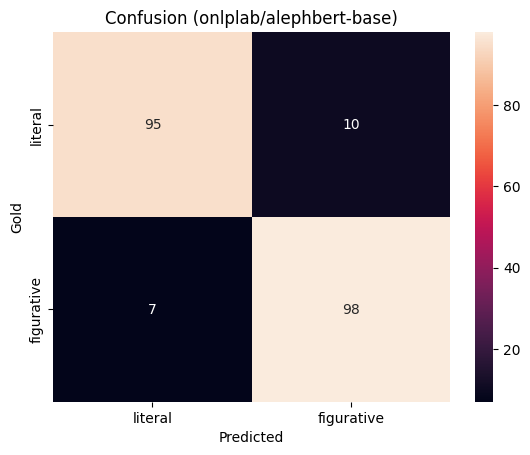

In [18]:
runner_alephbert.evaluate_on_test()

In [19]:
runner_alephbert.attach_predictions(df_test)

/tmp/ipykernel_1408/90842242.py:231: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(



How many correct?
correct
True     193
False     17
Name: count, dtype: int64 



,expression,sentence,labels,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,pred,gold,correct
0,נפל מהכיסא,"נפלתי מהכיסא ממה שהוא אמר לי באמצע השיעור, לא ...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,True
1,נפל מהכיסא,כולם נפלו מהכיסא כששמעו את התוצאה בבחינה הקשה.,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,True
2,נפל מהכיסא,היא נפלה מהכיסא כשגילתה את המחיר המופרך של העוף.,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,True
3,נפל מהכיסא,הילד נפל מהכיסא כששמע את השמועה על עצמו שכל חב...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,True
4,נפל מהכיסא,הם נפלו מהכיסאות כשגילו מי באמת עומד מאחורי הג...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,פתח דלתות,פתחתי את דלת הארון וגיליתי שם משהו מפתיע.,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,True
206,פתח דלתות,הם פתחו דלת ברזל ישנה שנחסמה על ידי שיחים.,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,True
207,פתח דלתות,הוא פתח את הדלת למעלית כדי להמתין לה.,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,True
208,פתח דלתות,הילד הקטן פתח את דלת המכונית לבד בפעם הראשונה.,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,True


/tmp/ipykernel_1408/90842242.py:262: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


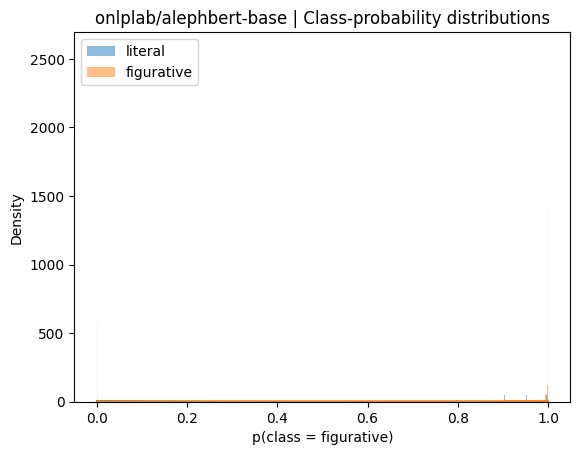

In [20]:
runner_alephbert.plot_probability_histogram()

/tmp/ipykernel_1408/90842242.py:290: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


AUC-ROC: 0.9788
Average Precision (AUPRC): 0.9788


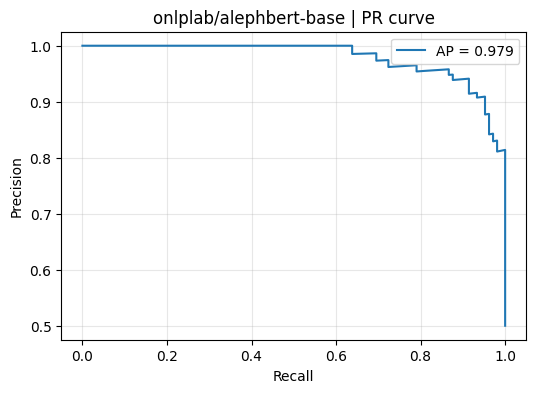

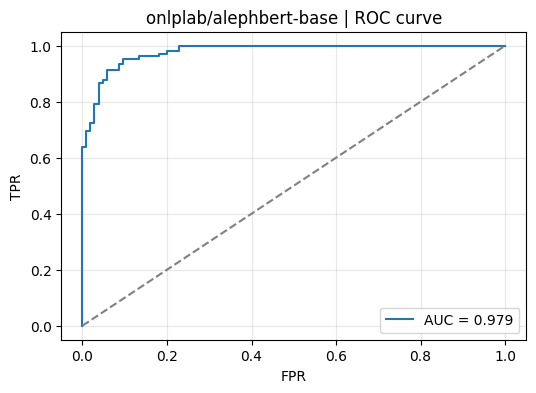

In [21]:
runner_alephbert.plot_pr_roc_curves()

In [22]:
runner_alephbert.find_best_f1_threshold()

/tmp/ipykernel_1408/90842242.py:332: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Best F1=0.930 at threshold=0.22


(np.float64(0.22), 0.9302325581395349)

/tmp/ipykernel_1408/90842242.py:362: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Brier score: 0.0703 (↓ better, perfect = 0)


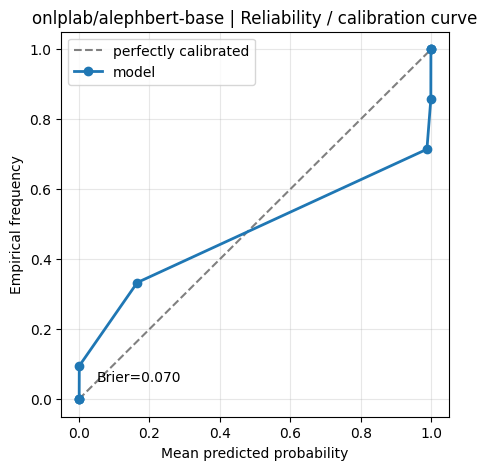

In [23]:
runner_alephbert.plot_calibration_curve()

/tmp/ipykernel_1408/90842242.py:398: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


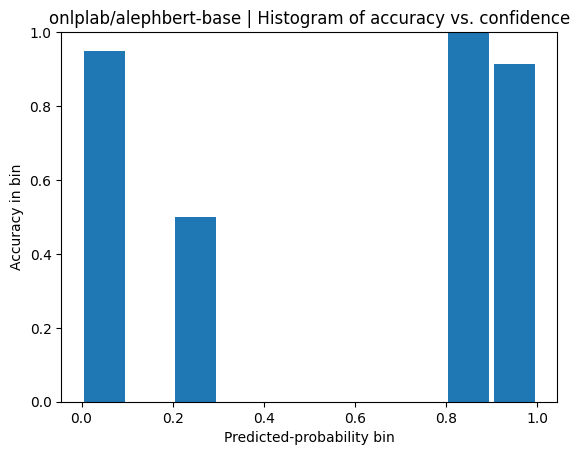

In [24]:
runner_alephbert.plot_accuracy_vs_confidence()

In [25]:
runner_alephbert.inspect_errors(df_test)

❌  A few errors ---------------------------


,sentence,expression,gold,pred,correct
44,המורה הרימה ידיים מהכיתה הרועשת והפסיקה לנסות ...,הרים ידיים,1,0,False
45,הילד הרים ידיים בהתלהבות כששמע שהוא עולה שלב ב...,הרים ידיים,0,1,False
55,כל התלמידים הרימו ידיים לשאלה של המורה בכיתה.,הרים ידיים,0,1,False
59,כולם הרימו ידיים כאות תמיכה במחאה נגד רשויות ה...,הרים ידיים,0,1,False
60,הקבלן חתך פינה במהלך עבודות השיפוץ וגרם לנזק ר...,חתך פינה,1,0,False
67,היא חתכה פינה בזמן הכנת העבודת גמר כדי להגיש ב...,חתך פינה,1,0,False
68,הם חתכו פינה בזמן הכנת הפרוייקט וזה התפוצץ להם...,חתך פינה,1,0,False
71,"כדי לחסוך בזמן, היא חתכה פינה ופספסה פרטים קרי...",חתך פינה,1,0,False
73,המהנדס חתך פינה בתכנון והמבנה יצא לא יציב.,חתך פינה,1,0,False
113,היא הלכה בין הטיפות בדרך הביתה מהלימודים.,הלך בין טיפות,0,1,False



✅  A few correct predictions --------------


,sentence,expression,gold,pred,correct
0,"נפלתי מהכיסא ממה שהוא אמר לי באמצע השיעור, לא ...",נפל מהכיסא,1,1,True
1,כולם נפלו מהכיסא כששמעו את התוצאה בבחינה הקשה.,נפל מהכיסא,1,1,True
2,היא נפלה מהכיסא כשגילתה את המחיר המופרך של העוף.,נפל מהכיסא,1,1,True
3,הילד נפל מהכיסא כששמע את השמועה על עצמו שכל חב...,נפל מהכיסא,1,1,True
4,הם נפלו מהכיסאות כשגילו מי באמת עומד מאחורי הג...,נפל מהכיסא,1,1,True
5,הבדיחה שהוא סיפר הייתה כל כך טובה שפשוט נפלתי ...,נפל מהכיסא,1,1,True
6,הוא נפל מהכיסא מרוב מבוכה על המקרה המטורף ברחוב.,נפל מהכיסא,1,1,True
7,חברי הקבוצה נפלו מהכיסא כשראו את הציונים בפרוי...,נפל מהכיסא,1,1,True
8,אני נופל מהכיסא כל פעם מחדש מהתגובות שלך.,נפל מהכיסא,1,1,True
9,התגובה שלה להצעת הנישואין הפילה אותו מהכיסא.,נפל מהכיסא,1,1,True


Parameter 'function'=<function IdiomExperiment.setup_zero_shot.<locals>.<lambda> at 0x7f38544c8540> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/210 [00:00<?, ? examples/s]

✅ Zero-shot dataset prepared


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1408/90842242.py:473: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


🔹 Zero-shot metrics: {'test_loss': 0.6951104402542114, 'test_model_preparation_time': 0.0081, 'test_runtime': 0.4634, 'test_samples_per_second': 453.164, 'test_steps_per_second': 30.211}
              precision    recall  f1-score   support

     literal       0.49      0.46      0.48       105
  figurative       0.50      0.53      0.51       105

    accuracy                           0.50       210
   macro avg       0.50      0.50      0.49       210
weighted avg       0.50      0.50      0.49       210

Confusion Matrix:
 [[48 57]
 [49 56]]


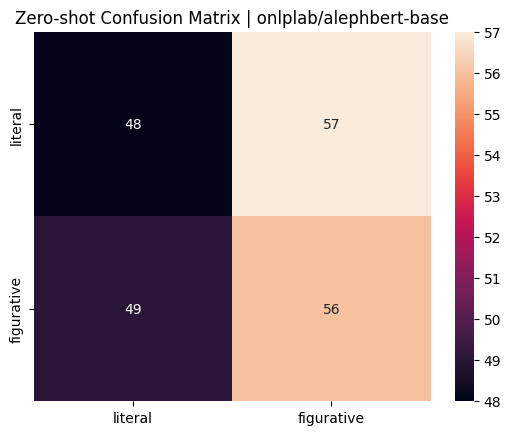

In [26]:
runner_alephbert.full_zero_shot_eval(df_test)

## XLM-RoBERTa

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

/tmp/ipykernel_1408/90842242.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-06 17:19:45,191] A new study created in memory with name: no-name-97342bf5-5ffc-42d5-8cd9-4204ec43e808
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.700500,0.662666,0.714286,0.702381
2,0.412600,0.590359,0.819048,0.816653
3,0.477600,0.612049,0.776190,0.769020
4,0.347700,0.558998,0.842857,0.841821
5,0.312100,0.565358,0.838095,0.836897


[I 2025-08-06 17:20:29,465] Trial 0 finished with value: 0.8368969298245614 and parameters: {'learning_rate': 1e-05, 'warmup_ratio': 0.1109328514540377, 'per_device_train_batch_size': 16, 'weight_decay': 0.0, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8368969298245614.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.711700,0.704020,0.500000,0.333333
2,0.721200,0.700091,0.500000,0.333333
3,0.697800,0.697634,0.500000,0.333333
4,0.703700,0.696716,0.500000,0.333333
5,0.694400,0.696526,0.500000,0.333333


[I 2025-08-06 17:21:14,883] Trial 1 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 1e-06, 'warmup_ratio': 0.1585014510079583, 'per_device_train_batch_size': 16, 'weight_decay': 0.0, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8368969298245614.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.705000,0.692716,0.500000,0.333333
2,0.573700,0.543008,0.804762,0.803151
3,0.478100,0.534739,0.800000,0.796380
4,0.426200,0.516913,0.828571,0.827002
5,0.420000,0.522094,0.828571,0.827002


[I 2025-08-06 17:22:02,652] Trial 2 finished with value: 0.8270022883295194 and parameters: {'learning_rate': 5e-06, 'warmup_ratio': 0.1078603886829664, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'label_smoothing_factor': 0.2, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8368969298245614.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.707100,0.694847,0.500000,0.333333
2,0.585200,0.568354,0.819048,0.817991
3,0.476300,0.507840,0.800000,0.796380
4,0.407400,0.512981,0.823810,0.821670
5,0.404300,0.510777,0.823810,0.822030


[I 2025-08-06 17:22:50,771] Trial 3 finished with value: 0.822029822029822 and parameters: {'learning_rate': 5e-06, 'warmup_ratio': 0.16477708579802278, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8368969298245614.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.702300,0.690265,0.500000,0.333333
2,0.559000,0.514639,0.800000,0.797781
3,0.482700,0.509599,0.800000,0.796887
4,0.437400,0.531029,0.804762,0.801955
5,0.428300,0.514314,0.804762,0.802790


[I 2025-08-06 17:23:35,462] Trial 4 finished with value: 0.8027898027898028 and parameters: {'learning_rate': 5e-06, 'warmup_ratio': 0.029654283993625307, 'per_device_train_batch_size': 16, 'weight_decay': 0.05, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.8368969298245614.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.709000,0.698324,0.500000,0.333333
2,0.644400,0.614998,0.780952,0.776988


[I 2025-08-06 17:23:55,283] Trial 5 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.690000,0.666899,0.561905,0.478458


[I 2025-08-06 17:24:14,099] Trial 6 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.673200,0.612304,0.780952,0.775056


[I 2025-08-06 17:24:33,645] Trial 7 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.642200,0.564675,0.766667,0.764741


[I 2025-08-06 17:24:52,764] Trial 8 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.659000,0.652516,0.795238,0.790054


[I 2025-08-06 17:25:11,574] Trial 9 pruned. 
/tmp/ipykernel_1408/90842242.py:151: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔎 Best run: BestRun(run_id='0', objective=0.8368969298245614, hyperparameters={'learning_rate': 1e-05, 'warmup_ratio': 0.1109328514540377, 'per_device_train_batch_size': 16, 'weight_decay': 0.0, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'cosine'}, run_summary=None)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.700500,0.662666,0.714286,0.702381
2,0.412600,0.590359,0.819048,0.816653
3,0.477600,0.612049,0.776190,0.769020
4,0.347700,0.558998,0.842857,0.841821
5,0.312100,0.565358,0.838095,0.836897


/tmp/ipykernel_1408/90842242.py:198: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Test metrics: {'test_loss': 0.23909766972064972, 'test_model_preparation_time': 0.0058, 'test_runtime': 0.7444, 'test_samples_per_second': 282.106, 'test_steps_per_second': 36.271}
              precision    recall  f1-score   support

     literal       0.91      0.93      0.92       105
  figurative       0.93      0.90      0.92       105

    accuracy                           0.92       210
   macro avg       0.92      0.92      0.92       210
weighted avg       0.92      0.92      0.92       210

CM
 [[98  7]
 [10 95]]


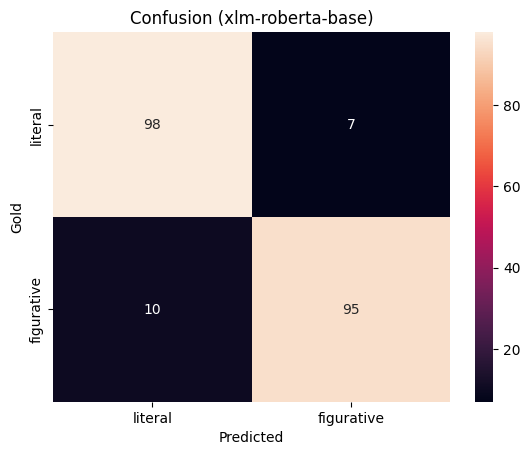

/tmp/ipykernel_1408/90842242.py:231: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(



How many correct?
correct
True     193
False     17
Name: count, dtype: int64 



/tmp/ipykernel_1408/90842242.py:262: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


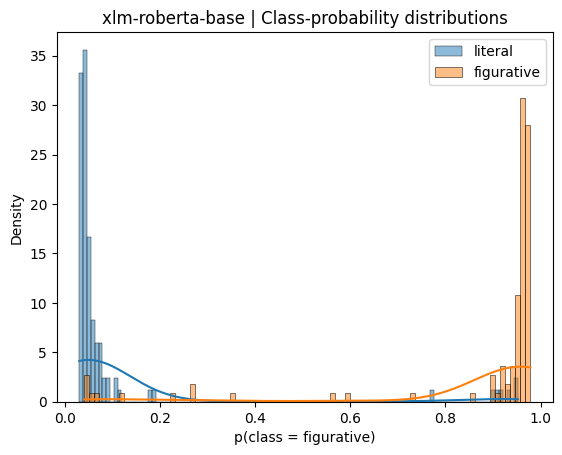

/tmp/ipykernel_1408/90842242.py:290: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


AUC-ROC: 0.9707
Average Precision (AUPRC): 0.9750


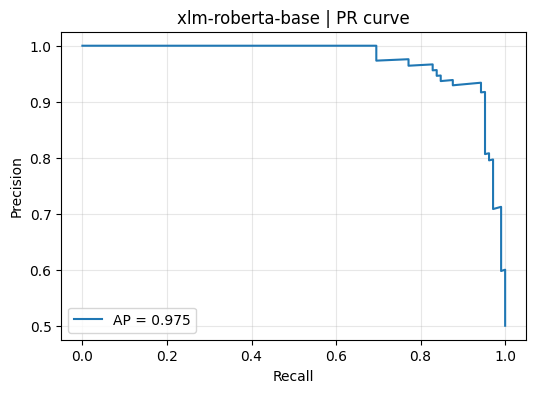

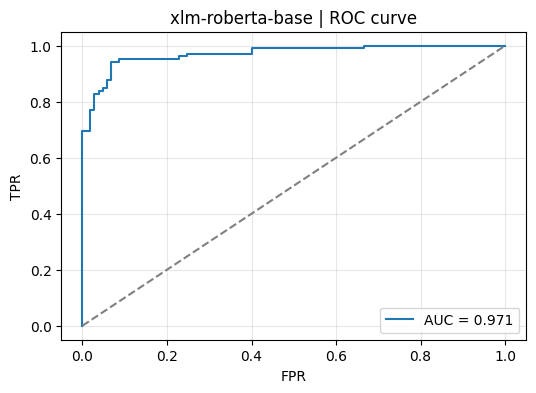

/tmp/ipykernel_1408/90842242.py:332: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Best F1=0.938 at threshold=0.19


/tmp/ipykernel_1408/90842242.py:362: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Brier score: 0.0670 (↓ better, perfect = 0)


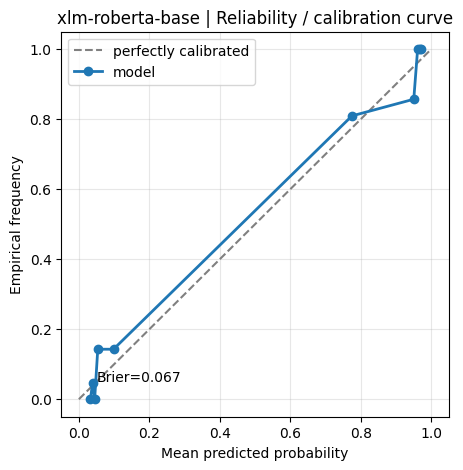

/tmp/ipykernel_1408/90842242.py:398: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


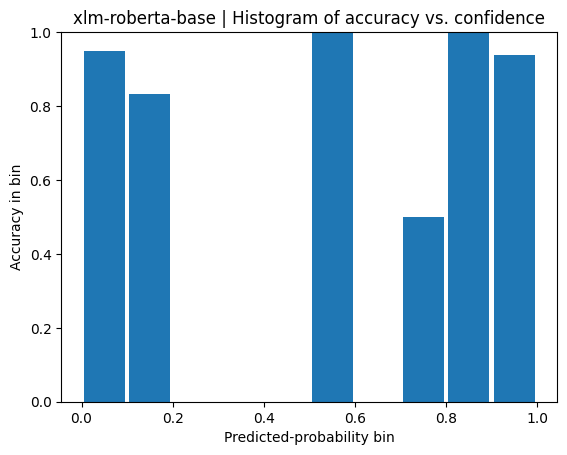

❌  A few errors ---------------------------


,sentence,expression,gold,pred,correct
0,"נפלתי מהכיסא ממה שהוא אמר לי באמצע השיעור, לא ...",נפל מהכיסא,1,0,False
6,הוא נפל מהכיסא מרוב מבוכה על המקרה המטורף ברחוב.,נפל מהכיסא,1,0,False
23,נפל מהכיסא בזמן שסובב אותו מהר מדי כשניסה לשחק...,נפל מהכיסא,0,1,False
28,הוא נפל מהכיסא כשניסה להגיע למשהו גבוה.,נפל מהכיסא,0,1,False
44,המורה הרימה ידיים מהכיתה הרועשת והפסיקה לנסות ...,הרים ידיים,1,0,False
45,הילד הרים ידיים בהתלהבות כששמע שהוא עולה שלב ב...,הרים ידיים,0,1,False
59,כולם הרימו ידיים כאות תמיכה במחאה נגד רשויות ה...,הרים ידיים,0,1,False
60,הקבלן חתך פינה במהלך עבודות השיפוץ וגרם לנזק ר...,חתך פינה,1,0,False
67,היא חתכה פינה בזמן הכנת העבודת גמר כדי להגיש ב...,חתך פינה,1,0,False
69,אסור לחתוך פינות כשמדובר בבטיחות.,חתך פינה,1,0,False



✅  A few correct predictions --------------


,sentence,expression,gold,pred,correct
1,כולם נפלו מהכיסא כששמעו את התוצאה בבחינה הקשה.,נפל מהכיסא,1,1,True
2,היא נפלה מהכיסא כשגילתה את המחיר המופרך של העוף.,נפל מהכיסא,1,1,True
3,הילד נפל מהכיסא כששמע את השמועה על עצמו שכל חב...,נפל מהכיסא,1,1,True
4,הם נפלו מהכיסאות כשגילו מי באמת עומד מאחורי הג...,נפל מהכיסא,1,1,True
5,הבדיחה שהוא סיפר הייתה כל כך טובה שפשוט נפלתי ...,נפל מהכיסא,1,1,True
7,חברי הקבוצה נפלו מהכיסא כשראו את הציונים בפרוי...,נפל מהכיסא,1,1,True
8,אני נופל מהכיסא כל פעם מחדש מהתגובות שלך.,נפל מהכיסא,1,1,True
9,התגובה שלה להצעת הנישואין הפילה אותו מהכיסא.,נפל מהכיסא,1,1,True
10,נפלתי מהכיסא כשקראתי את ההודעה ששלחת בקבוצה של...,נפל מהכיסא,1,1,True
11,היא נפלה מהכיסא כשראתה מי הגיע למסיבה בהפתעה א...,נפל מהכיסא,1,1,True


In [27]:
runner_xlmroberta = IdiomExperiment("xlm-roberta-base", "XLMRoberta_idiom_full")
runner_xlmroberta.setup()
runner_xlmroberta.run_optuna()
runner_xlmroberta.train_final_model()
runner_xlmroberta.evaluate_on_test()
runner_xlmroberta.attach_predictions(df_test)
runner_xlmroberta.plot_probability_histogram()
runner_xlmroberta.plot_pr_roc_curves()
runner_xlmroberta.find_best_f1_threshold()
runner_xlmroberta.plot_calibration_curve()
runner_xlmroberta.plot_accuracy_vs_confidence()
runner_xlmroberta.inspect_errors(df_test)

### ZeroShot XLMRoberta

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

✅ Zero-shot dataset prepared


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1408/90842242.py:473: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


🔹 Zero-shot metrics: {'test_loss': 0.7051597833633423, 'test_model_preparation_time': 0.0081, 'test_runtime': 0.4293, 'test_samples_per_second': 489.152, 'test_steps_per_second': 32.61}
              precision    recall  f1-score   support

     literal       0.50      1.00      0.67       105
  figurative       0.00      0.00      0.00       105

    accuracy                           0.50       210
   macro avg       0.25      0.50      0.33       210
weighted avg       0.25      0.50      0.33       210

Confusion Matrix:
 [[105   0]
 [105   0]]


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


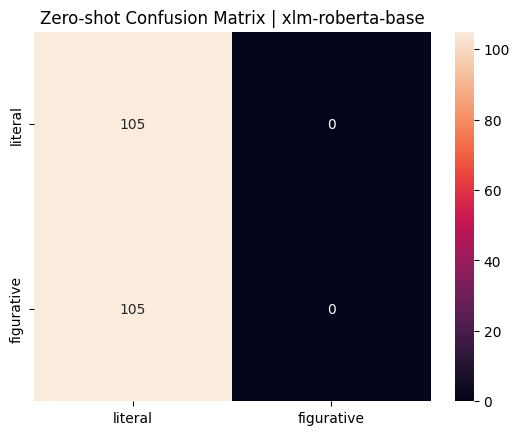

In [28]:
runner_xlmroberta.full_zero_shot_eval(df_test)

### Frozen XLMRoberta

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

/tmp/ipykernel_1408/1121091033.py:569: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-06 18:54:29,971] A new study created in memory with name: no-name-ad76bff2-96fc-4bdf-a029-6fee4df0d8d4
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be ab

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.703000,0.678271,0.509524,0.354155
2,0.576600,0.545410,0.761905,0.750972
3,0.487600,0.502291,0.861905,0.860994


[I 2025-08-06 18:54:42,669] Trial 0 finished with value: 0.8609938143388647 and parameters: {'learning_rate': 0.003, 'warmup_ratio': 0.14772213140165721, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8609938143388647.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.747100,0.689588,0.500000,0.333333
2,0.719400,0.624167,0.590476,0.507956
3,0.598700,0.582567,0.809524,0.804996


[I 2025-08-06 18:54:52,771] Trial 1 finished with value: 0.8049958213390287 and parameters: {'learning_rate': 0.003, 'warmup_ratio': 0.17258921718604314, 'per_device_train_batch_size': 32, 'weight_decay': 0.01, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8609938143388647.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.733700,0.730276,0.500000,0.333333
2,0.665800,0.655715,0.619048,0.561632
3,0.633600,0.650498,0.661905,0.620987


[I 2025-08-06 18:55:05,269] Trial 2 finished with value: 0.6209868069854343 and parameters: {'learning_rate': 0.0005, 'warmup_ratio': 0.16581486302984624, 'per_device_train_batch_size': 16, 'weight_decay': 0.0, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8609938143388647.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.689500,0.643134,0.571429,0.475000
2,0.570800,0.666983,0.514286,0.364316
3,0.540800,0.572047,0.714286,0.690691


[I 2025-08-06 18:55:23,577] Trial 3 finished with value: 0.6906912804399057 and parameters: {'learning_rate': 0.001, 'warmup_ratio': 0.1901725518422744, 'per_device_train_batch_size': 8, 'weight_decay': 0.0, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.8609938143388647.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.708300,0.681077,0.504762,0.343829
2,0.673000,0.704382,0.500000,0.333333
3,0.665700,0.660773,0.814286,0.810675


[I 2025-08-06 18:55:33,531] Trial 4 finished with value: 0.8106752352111699 and parameters: {'learning_rate': 0.0005, 'warmup_ratio': 0.1933845200001024, 'per_device_train_batch_size': 32, 'weight_decay': 0.01, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8609938143388647.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.727100,0.718162,0.500000,0.333333


[I 2025-08-06 18:55:38,587] Trial 5 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.690300,0.686842,0.500000,0.333333


[I 2025-08-06 18:55:46,001] Trial 6 pruned. 
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.700100,0.695125,0.500000,0.333333


[I 2025-08-06 18:55:50,384] Trial 7 pruned. 
/tmp/ipykernel_1408/1121091033.py:637: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔎 Best run (Frozen): BestRun(run_id='0', objective=0.8609938143388647, hyperparameters={'learning_rate': 0.003, 'warmup_ratio': 0.14772213140165721, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}, run_summary=None)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.695100,0.714429,0.504762,0.343829
2,0.509900,0.582199,0.680952,0.644796
3,0.409100,0.468287,0.804762,0.799819


🔹 Evaluating frozen model...



/tmp/ipykernel_1408/1121091033.py:198: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Test metrics: {'test_loss': 0.368221253156662, 'test_model_preparation_time': 0.006, 'test_runtime': 0.7949, 'test_samples_per_second': 264.189, 'test_steps_per_second': 33.967}
              precision    recall  f1-score   support

     literal       0.90      0.78      0.84       105
  figurative       0.81      0.91      0.86       105

    accuracy                           0.85       210
   macro avg       0.85      0.85      0.85       210
weighted avg       0.85      0.85      0.85       210

CM
 [[82 23]
 [ 9 96]]


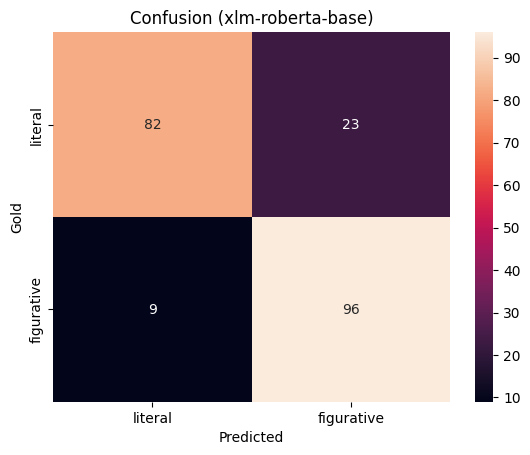

/tmp/ipykernel_1408/1121091033.py:231: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(



How many correct?
correct
True     178
False     32
Name: count, dtype: int64 



/tmp/ipykernel_1408/1121091033.py:262: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


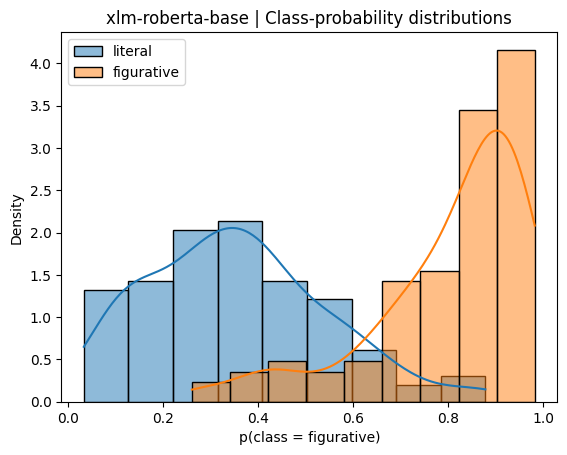

/tmp/ipykernel_1408/1121091033.py:290: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


AUC-ROC: 0.9495
Average Precision (AUPRC): 0.9545


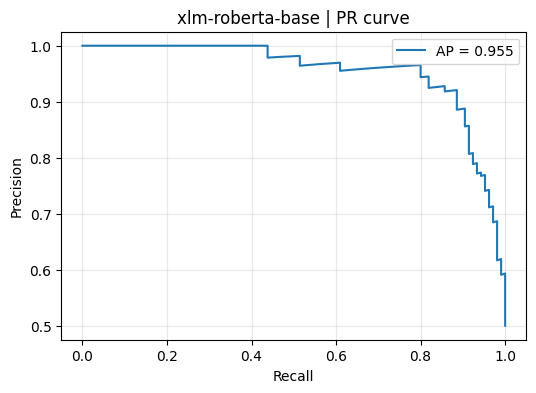

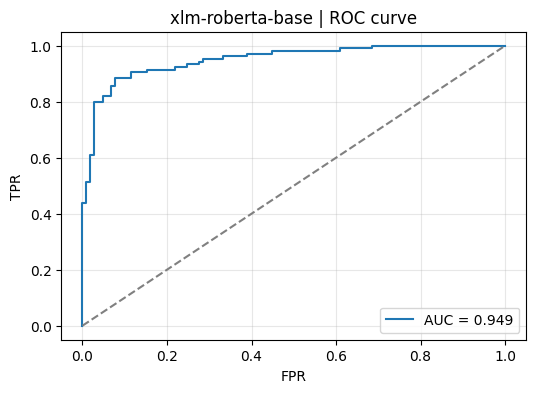

/tmp/ipykernel_1408/1121091033.py:332: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Best F1=0.903 at threshold=0.61


/tmp/ipykernel_1408/1121091033.py:362: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Brier score: 0.1120 (↓ better, perfect = 0)


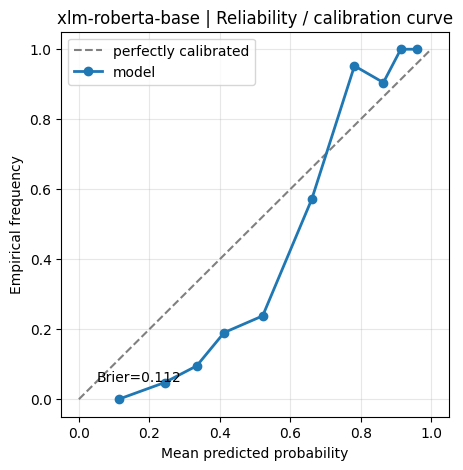

/tmp/ipykernel_1408/1121091033.py:398: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


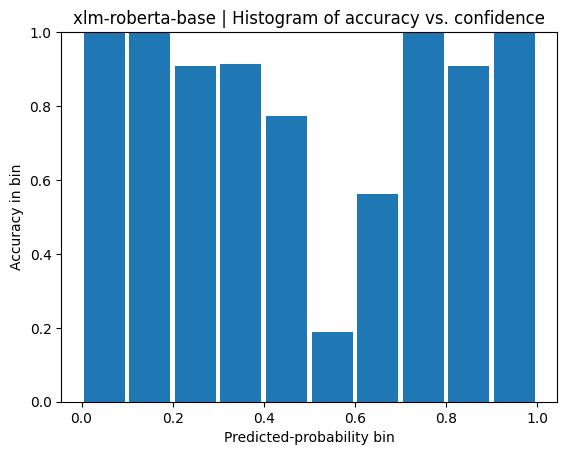

❌  A few errors ---------------------------


,sentence,expression,gold,pred,correct
0,"נפלתי מהכיסא ממה שהוא אמר לי באמצע השיעור, לא ...",נפל מהכיסא,1,0,False
6,הוא נפל מהכיסא מרוב מבוכה על המקרה המטורף ברחוב.,נפל מהכיסא,1,0,False
13,כולנו נפלנו מהכיסא כשראינו את התוצאה הסופית של...,נפל מהכיסא,1,0,False
26,הסטודנט נפל מהכיסא בזמן כתיבה כי החליק.,נפל מהכיסא,0,1,False
55,כל התלמידים הרימו ידיים לשאלה של המורה בכיתה.,הרים ידיים,0,1,False
59,כולם הרימו ידיים כאות תמיכה במחאה נגד רשויות ה...,הרים ידיים,0,1,False
60,הקבלן חתך פינה במהלך עבודות השיפוץ וגרם לנזק ר...,חתך פינה,1,0,False
67,היא חתכה פינה בזמן הכנת העבודת גמר כדי להגיש ב...,חתך פינה,1,0,False
68,הם חתכו פינה בזמן הכנת הפרוייקט וזה התפוצץ להם...,חתך פינה,1,0,False
69,אסור לחתוך פינות כשמדובר בבטיחות.,חתך פינה,1,0,False



✅  A few correct predictions --------------


,sentence,expression,gold,pred,correct
1,כולם נפלו מהכיסא כששמעו את התוצאה בבחינה הקשה.,נפל מהכיסא,1,1,True
2,היא נפלה מהכיסא כשגילתה את המחיר המופרך של העוף.,נפל מהכיסא,1,1,True
3,הילד נפל מהכיסא כששמע את השמועה על עצמו שכל חב...,נפל מהכיסא,1,1,True
4,הם נפלו מהכיסאות כשגילו מי באמת עומד מאחורי הג...,נפל מהכיסא,1,1,True
5,הבדיחה שהוא סיפר הייתה כל כך טובה שפשוט נפלתי ...,נפל מהכיסא,1,1,True
7,חברי הקבוצה נפלו מהכיסא כשראו את הציונים בפרוי...,נפל מהכיסא,1,1,True
8,אני נופל מהכיסא כל פעם מחדש מהתגובות שלך.,נפל מהכיסא,1,1,True
9,התגובה שלה להצעת הנישואין הפילה אותו מהכיסא.,נפל מהכיסא,1,1,True
10,נפלתי מהכיסא כשקראתי את ההודעה ששלחת בקבוצה של...,נפל מהכיסא,1,1,True
11,היא נפלה מהכיסא כשראתה מי הגיע למסיבה בהפתעה א...,נפל מהכיסא,1,1,True


In [39]:
runner_frozen_xlmr = IdiomExperiment("xlm-roberta-base", "xlmr_frozen_idiom")

# 1️⃣ Setup
runner_frozen_xlmr.setup()

# 2️⃣ Optuna hyperparameter search with frozen encoder
runner_frozen_xlmr.run_optuna_frozen()

# 3️⃣ Train final model (frozen encoder)
runner_frozen_xlmr.train_final_frozen_model()

# 4️⃣ Evaluate everything on frozen model
runner_frozen_xlmr.evaluate_all_frozen(df_test)


## AlephBERT Gimmel (Dicta)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Parameter 'function'=<function IdiomExperiment.setup.<locals>.tokenize_function at 0x7fed44c50040> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

/tmp/ipykernel_93/1121091033.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-10 19:34:09,854] A new study created in memory with name: no-name-c5ad6500-eb96-4889-b031-440d0778858e
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.662000,0.647471,0.628571,0.602273
2,0.479600,0.499945,0.814286,0.813944
3,0.414300,0.440624,0.866667,0.866364
4,0.324800,0.412859,0.876190,0.875468
5,0.287700,0.415779,0.880952,0.880342


[I 2025-08-10 19:34:40,116] Trial 0 finished with value: 0.8803418803418803 and parameters: {'learning_rate': 1e-05, 'warmup_ratio': 0.1800593769864697, 'per_device_train_batch_size': 8, 'weight_decay': 0.01, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.8803418803418803.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.713500,0.704468,0.523810,0.517508
2,0.729900,0.690569,0.580952,0.574429
3,0.702300,0.684573,0.580952,0.580610
4,0.701700,0.681763,0.614286,0.613857
5,0.691700,0.681281,0.614286,0.613857


[I 2025-08-10 19:34:58,511] Trial 1 finished with value: 0.6138566661369775 and parameters: {'learning_rate': 1e-06, 'warmup_ratio': 0.0102327745736148, 'per_device_train_batch_size': 16, 'weight_decay': 0.05, 'label_smoothing_factor': 0.2, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8803418803418803.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.692000,0.666185,0.623810,0.615429
2,0.646800,0.608164,0.757143,0.755897
3,0.573200,0.567209,0.785714,0.783550
4,0.546100,0.551861,0.790476,0.787703
5,0.521500,0.546150,0.823810,0.821670


[I 2025-08-10 19:35:17,530] Trial 2 finished with value: 0.8216703770856763 and parameters: {'learning_rate': 5e-06, 'warmup_ratio': 0.05078720963248618, 'per_device_train_batch_size': 16, 'weight_decay': 0.05, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.8803418803418803.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.585700,0.560108,0.819048,0.817391
2,0.426000,0.440652,0.861905,0.861197
3,0.351000,0.421020,0.890476,0.889754
4,0.294400,0.410277,0.890476,0.889915
5,0.287900,0.415230,0.890476,0.889754


[I 2025-08-10 19:35:51,111] Trial 3 finished with value: 0.8897537148204788 and parameters: {'learning_rate': 1e-05, 'warmup_ratio': 0.07875146282710577, 'per_device_train_batch_size': 8, 'weight_decay': 0.05, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 3 with value: 0.8897537148204788.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.539700,0.520688,0.847619,0.846729
2,0.311100,0.382296,0.900000,0.899980
3,0.287500,0.449601,0.880952,0.880494
4,0.218500,0.431205,0.895238,0.894463
5,0.201700,0.449077,0.885714,0.884668


[I 2025-08-10 19:36:24,374] Trial 4 finished with value: 0.8846681922196797 and parameters: {'learning_rate': 5e-05, 'warmup_ratio': 0.25638387696521264, 'per_device_train_batch_size': 8, 'weight_decay': 0.0, 'label_smoothing_factor': 0.2, 'lr_scheduler_type': 'linear'}. Best is trial 3 with value: 0.8897537148204788.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.664200,0.621548,0.752381,0.747222
2,0.531500,0.508752,0.852381,0.851624
3,0.434700,0.490660,0.842857,0.840216
4,0.384700,0.457296,0.866667,0.865446
5,0.364600,0.453665,0.866667,0.865446


[I 2025-08-10 19:36:42,585] Trial 5 finished with value: 0.8654462242562929 and parameters: {'learning_rate': 1e-05, 'warmup_ratio': 0.042643485965465654, 'per_device_train_batch_size': 16, 'weight_decay': 0.0, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'linear'}. Best is trial 3 with value: 0.8897537148204788.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.643300,0.483695,0.847619,0.845928
2,0.297200,0.376579,0.876190,0.876011
3,0.230700,0.430720,0.880952,0.880494
4,0.215800,0.440201,0.885714,0.884668
5,0.207900,0.423627,0.890476,0.889754


[I 2025-08-10 19:37:00,222] Trial 6 finished with value: 0.8897537148204788 and parameters: {'learning_rate': 5e-05, 'warmup_ratio': 0.13466722335963238, 'per_device_train_batch_size': 16, 'weight_decay': 0.0, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'cosine'}. Best is trial 3 with value: 0.8897537148204788.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.622300,0.635050,0.704762,0.702577


[I 2025-08-10 19:37:07,830] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.711400,0.680850,0.604762,0.598119


[I 2025-08-10 19:37:15,092] Trial 8 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.598700,0.567623,0.804762,0.804651


[I 2025-08-10 19:37:21,565] Trial 9 pruned. 
/tmp/ipykernel_93/1121091033.py:151: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔎 Best run: BestRun(run_id='3', objective=0.8897537148204788, hyperparameters={'learning_rate': 1e-05, 'warmup_ratio': 0.07875146282710577, 'per_device_train_batch_size': 8, 'weight_decay': 0.05, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}, run_summary=None)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.563800,0.533529,0.809524,0.808900
2,0.355200,0.396667,0.861905,0.861751
3,0.277000,0.368304,0.876190,0.875785
4,0.208000,0.353240,0.880952,0.880342
5,0.183500,0.360547,0.876190,0.875468


/tmp/ipykernel_93/1121091033.py:198: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Test metrics: {'test_loss': 0.2298315465450287, 'test_model_preparation_time': 0.0026, 'test_runtime': 0.2393, 'test_samples_per_second': 877.637, 'test_steps_per_second': 112.839}
              precision    recall  f1-score   support

     literal       0.95      0.93      0.94       105
  figurative       0.93      0.95      0.94       105

    accuracy                           0.94       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.94      0.94       210

CM
 [[ 98   7]
 [  5 100]]


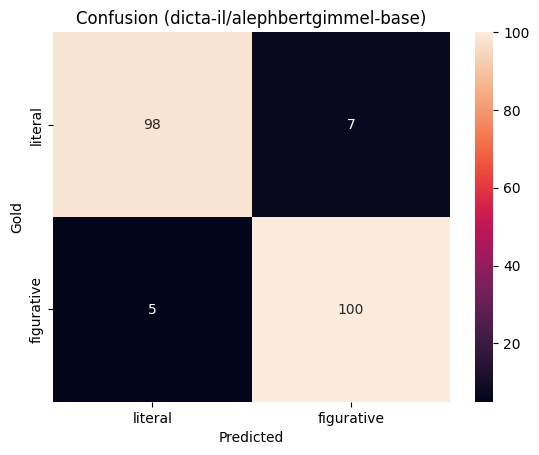

/tmp/ipykernel_93/1121091033.py:231: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(



How many correct?
correct
True     198
False     12
Name: count, dtype: int64 



/tmp/ipykernel_93/1121091033.py:262: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


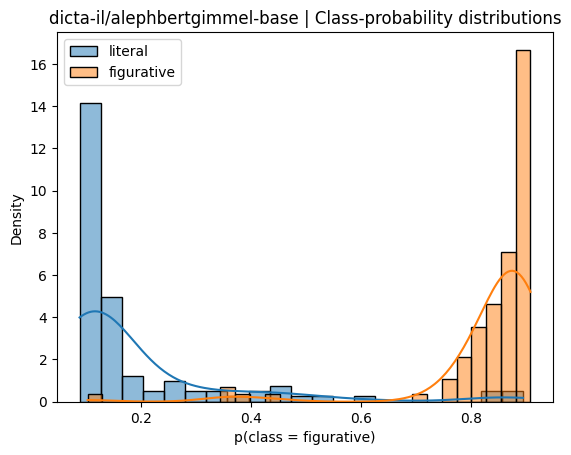

/tmp/ipykernel_93/1121091033.py:290: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


AUC-ROC: 0.9740
Average Precision (AUPRC): 0.9690


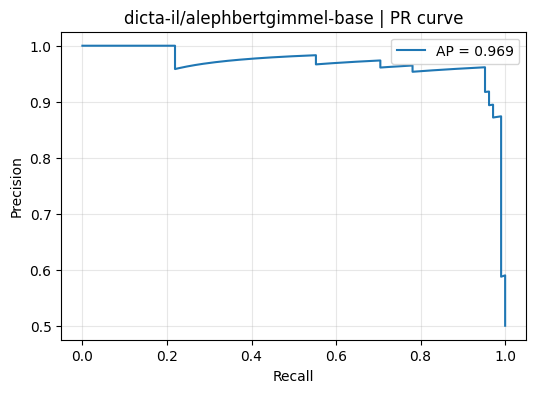

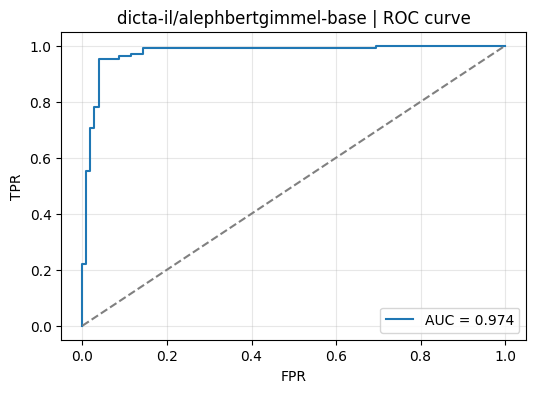

/tmp/ipykernel_93/1121091033.py:332: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Best F1=0.957 at threshold=0.62


/tmp/ipykernel_93/1121091033.py:362: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Brier score: 0.0541 (↓ better, perfect = 0)


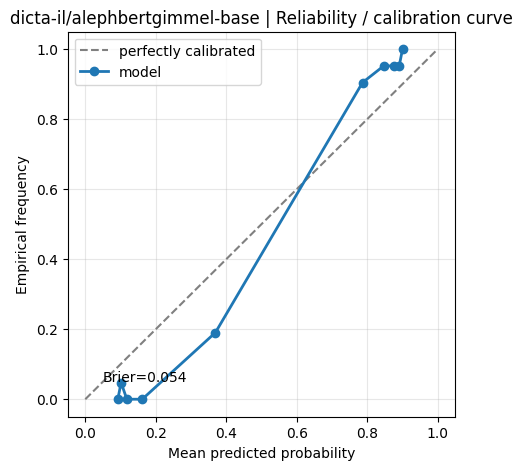

/tmp/ipykernel_93/1121091033.py:398: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


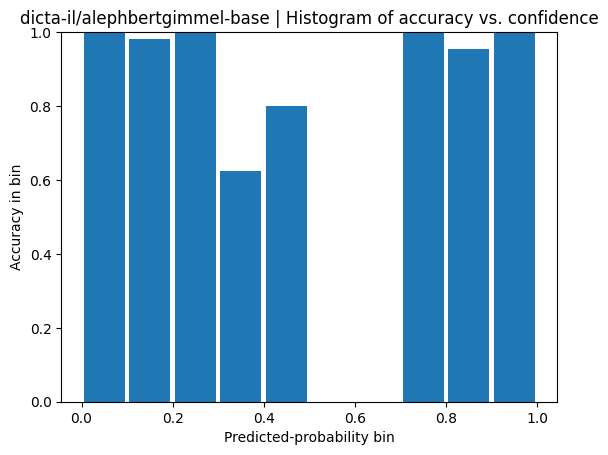

❌  A few errors ---------------------------


,sentence,expression,gold,pred,correct
45,הילד הרים ידיים בהתלהבות כששמע שהוא עולה שלב ב...,הרים ידיים,0,1,False
48,הוא הרים ידיים כדי להשתתף בחידון בכיתה.,הרים ידיים,0,1,False
55,כל התלמידים הרימו ידיים לשאלה של המורה בכיתה.,הרים ידיים,0,1,False
59,כולם הרימו ידיים כאות תמיכה במחאה נגד רשויות ה...,הרים ידיים,0,1,False
60,הקבלן חתך פינה במהלך עבודות השיפוץ וגרם לנזק ר...,חתך פינה,1,0,False
67,היא חתכה פינה בזמן הכנת העבודת גמר כדי להגיש ב...,חתך פינה,1,0,False
71,"כדי לחסוך בזמן, היא חתכה פינה ופספסה פרטים קרי...",חתך פינה,1,0,False
73,המהנדס חתך פינה בתכנון והמבנה יצא לא יציב.,חתך פינה,1,0,False
167,"היא פקחה עיניים מוקדם מהרגיל, כאילו הרגישה שמח...",פתח עיניים,0,1,False
172,היא פקחה עיניים וראתה אור ראשון בפעם הראשונה.,פתח עיניים,0,1,False



✅  A few correct predictions --------------


,sentence,expression,gold,pred,correct
0,"נפלתי מהכיסא ממה שהוא אמר לי באמצע השיעור, לא ...",נפל מהכיסא,1,1,True
1,כולם נפלו מהכיסא כששמעו את התוצאה בבחינה הקשה.,נפל מהכיסא,1,1,True
2,היא נפלה מהכיסא כשגילתה את המחיר המופרך של העוף.,נפל מהכיסא,1,1,True
3,הילד נפל מהכיסא כששמע את השמועה על עצמו שכל חב...,נפל מהכיסא,1,1,True
4,הם נפלו מהכיסאות כשגילו מי באמת עומד מאחורי הג...,נפל מהכיסא,1,1,True
5,הבדיחה שהוא סיפר הייתה כל כך טובה שפשוט נפלתי ...,נפל מהכיסא,1,1,True
6,הוא נפל מהכיסא מרוב מבוכה על המקרה המטורף ברחוב.,נפל מהכיסא,1,1,True
7,חברי הקבוצה נפלו מהכיסא כשראו את הציונים בפרוי...,נפל מהכיסא,1,1,True
8,אני נופל מהכיסא כל פעם מחדש מהתגובות שלך.,נפל מהכיסא,1,1,True
9,התגובה שלה להצעת הנישואין הפילה אותו מהכיסא.,נפל מהכיסא,1,1,True


In [19]:
runner_alephgimmel = IdiomExperiment("dicta-il/alephbertgimmel-base", "AlephBERTGimmel_idiom_full")
runner_alephgimmel.setup()
runner_alephgimmel.run_optuna()
runner_alephgimmel.train_final_model()
runner_alephgimmel.evaluate_on_test()
runner_alephgimmel.attach_predictions(df_test)
runner_alephgimmel.plot_probability_histogram()
runner_alephgimmel.plot_pr_roc_curves()
runner_alephgimmel.find_best_f1_threshold()
runner_alephgimmel.plot_calibration_curve()
runner_alephgimmel.plot_accuracy_vs_confidence()
runner_alephgimmel.inspect_errors(df_test)

### ZeroShot AlephBERTGimmel

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

✅ Zero-shot dataset prepared


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1408/90842242.py:473: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


🔹 Zero-shot metrics: {'test_loss': 0.8440209031105042, 'test_model_preparation_time': 0.0064, 'test_runtime': 0.4365, 'test_samples_per_second': 481.128, 'test_steps_per_second': 32.075}
              precision    recall  f1-score   support

     literal       0.00      0.00      0.00       105
  figurative       0.50      1.00      0.67       105

    accuracy                           0.50       210
   macro avg       0.25      0.50      0.33       210
weighted avg       0.25      0.50      0.33       210

Confusion Matrix:
 [[  0 105]
 [  0 105]]


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


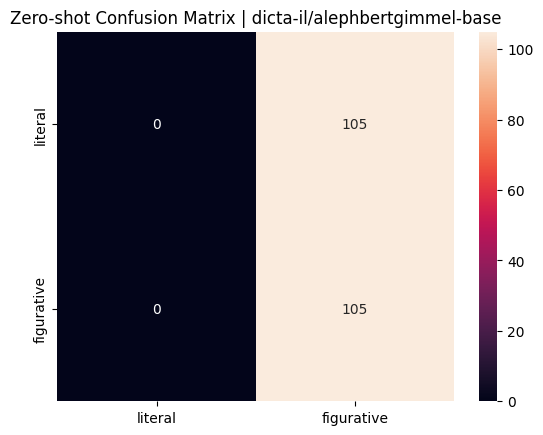

In [31]:
runner_alephgimmel.full_zero_shot_eval(df_test)

### Frozen AlephBERTGimmel

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

/tmp/ipykernel_1408/1121091033.py:569: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-06 19:01:45,438] A new study created in memory with name: no-name-ec191c99-b41f-4969-89ac-981e2778afc9
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.729700,0.647195,0.647619,0.647491
2,0.655400,0.632103,0.685714,0.685258
3,0.622200,0.628455,0.676190,0.675130


[I 2025-08-06 19:01:54,033] Trial 0 finished with value: 0.6751296751296751 and parameters: {'learning_rate': 0.001, 'warmup_ratio': 0.13660852993408443, 'per_device_train_batch_size': 32, 'weight_decay': 0.01, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.6751296751296751.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.710800,0.699878,0.514286,0.467905
2,0.740500,0.685927,0.538095,0.538001
3,0.702400,0.684605,0.509524,0.502473


[I 2025-08-06 19:02:05,256] Trial 1 finished with value: 0.5024726854514089 and parameters: {'learning_rate': 0.0001, 'warmup_ratio': 0.09077884376309, 'per_device_train_batch_size': 16, 'weight_decay': 0.0, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.6751296751296751.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.722700,0.706314,0.514286,0.496000
2,0.695100,0.695050,0.519048,0.499988
3,0.682800,0.691011,0.523810,0.521029


[I 2025-08-06 19:02:22,033] Trial 2 finished with value: 0.5210291031840161 and parameters: {'learning_rate': 5e-05, 'warmup_ratio': 0.19861585484920824, 'per_device_train_batch_size': 8, 'weight_decay': 0.0, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.6751296751296751.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.728800,0.715346,0.476190,0.454365
2,0.739500,0.708020,0.485714,0.484967
3,0.711900,0.706666,0.490476,0.487115


[I 2025-08-06 19:02:30,579] Trial 3 finished with value: 0.48711510807787994 and parameters: {'learning_rate': 5e-05, 'warmup_ratio': 0.16393114897487077, 'per_device_train_batch_size': 32, 'weight_decay': 0.0, 'label_smoothing_factor': 0.05, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.6751296751296751.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.727300,0.708023,0.500000,0.482139
2,0.730400,0.698914,0.490476,0.474152
3,0.707000,0.695699,0.523810,0.519451


[I 2025-08-06 19:02:39,132] Trial 4 finished with value: 0.5194508009153318 and parameters: {'learning_rate': 0.0001, 'warmup_ratio': 0.1340402998543426, 'per_device_train_batch_size': 32, 'weight_decay': 0.0, 'label_smoothing_factor': 0.05, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.6751296751296751.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.634000,0.638299,0.614286,0.554374
2,0.533100,0.592753,0.690476,0.665859
3,0.524100,0.562881,0.747619,0.747613


[I 2025-08-06 19:02:55,898] Trial 5 finished with value: 0.7476133245651828 and parameters: {'learning_rate': 0.001, 'warmup_ratio': 0.05844141307737954, 'per_device_train_batch_size': 8, 'weight_decay': 0.01, 'label_smoothing_factor': 0.05, 'lr_scheduler_type': 'cosine'}. Best is trial 5 with value: 0.7476133245651828.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.705000,0.638675,0.666667,0.662968
2,0.606100,0.648986,0.619048,0.561632
3,0.599600,0.602309,0.709524,0.708406


[I 2025-08-06 19:03:07,118] Trial 6 finished with value: 0.7084063645261888 and parameters: {'learning_rate': 0.001, 'warmup_ratio': 0.13178771758580243, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'linear'}. Best is trial 5 with value: 0.7476133245651828.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.717300,0.699516,0.528571,0.393860


[I 2025-08-06 19:03:11,801] Trial 7 pruned. 
/tmp/ipykernel_1408/1121091033.py:637: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔎 Best run (Frozen): BestRun(run_id='5', objective=0.7476133245651828, hyperparameters={'learning_rate': 0.001, 'warmup_ratio': 0.05844141307737954, 'per_device_train_batch_size': 8, 'weight_decay': 0.01, 'label_smoothing_factor': 0.05, 'lr_scheduler_type': 'cosine'}, run_summary=None)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.631900,0.667712,0.580952,0.496513
2,0.512200,0.583313,0.690476,0.665859
3,0.507300,0.553185,0.738095,0.738089


🔹 Evaluating frozen model...



/tmp/ipykernel_1408/1121091033.py:198: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Test metrics: {'test_loss': 0.48438915610313416, 'test_model_preparation_time': 0.0082, 'test_runtime': 0.699, 'test_samples_per_second': 300.413, 'test_steps_per_second': 38.625}
              precision    recall  f1-score   support

     literal       0.79      0.89      0.84       105
  figurative       0.87      0.77      0.82       105

    accuracy                           0.83       210
   macro avg       0.83      0.83      0.83       210
weighted avg       0.83      0.83      0.83       210

CM
 [[93 12]
 [24 81]]


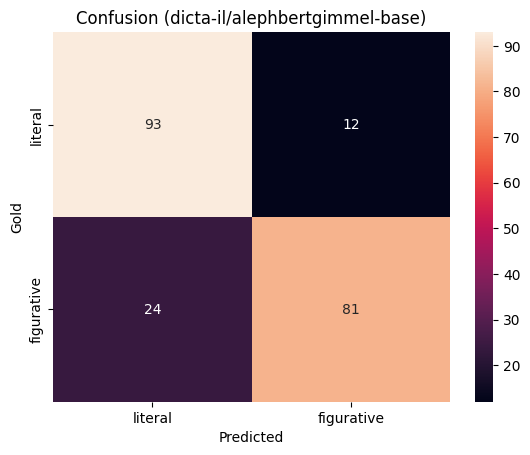

/tmp/ipykernel_1408/1121091033.py:231: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(



How many correct?
correct
True     174
False     36
Name: count, dtype: int64 



/tmp/ipykernel_1408/1121091033.py:262: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


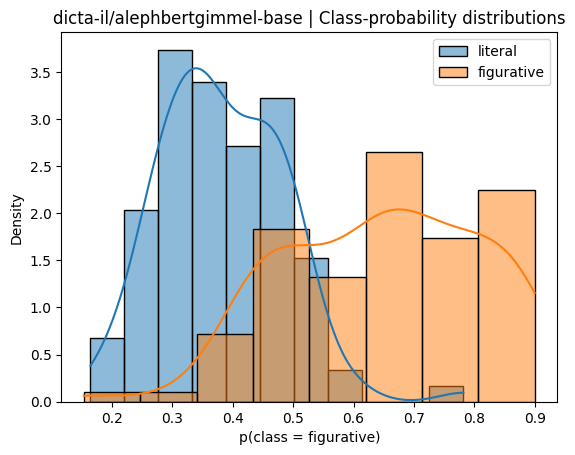

/tmp/ipykernel_1408/1121091033.py:290: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


AUC-ROC: 0.9122
Average Precision (AUPRC): 0.9241


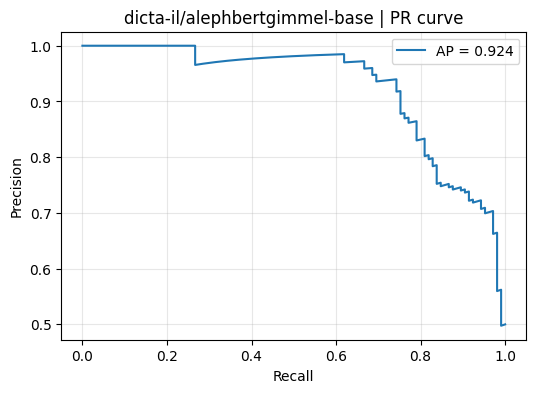

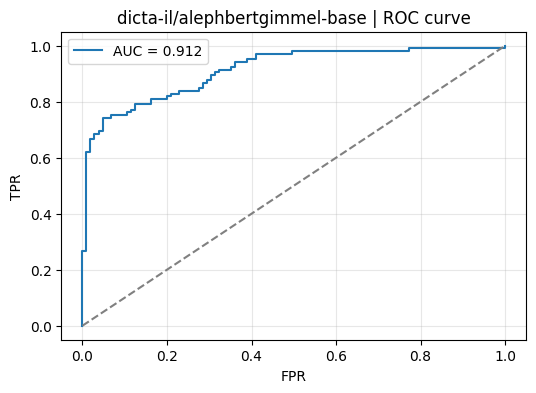

/tmp/ipykernel_1408/1121091033.py:332: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Best F1=0.827 at threshold=0.52


/tmp/ipykernel_1408/1121091033.py:362: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Brier score: 0.1534 (↓ better, perfect = 0)


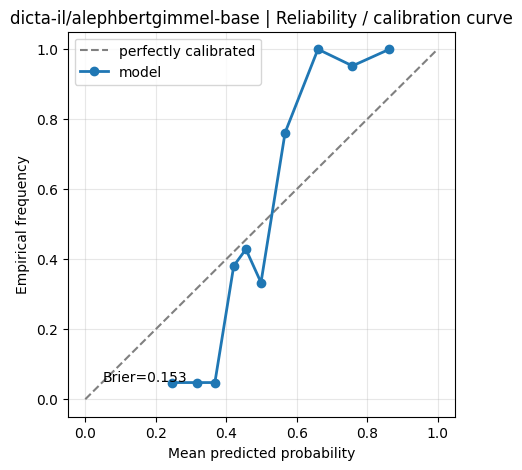

/tmp/ipykernel_1408/1121091033.py:398: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


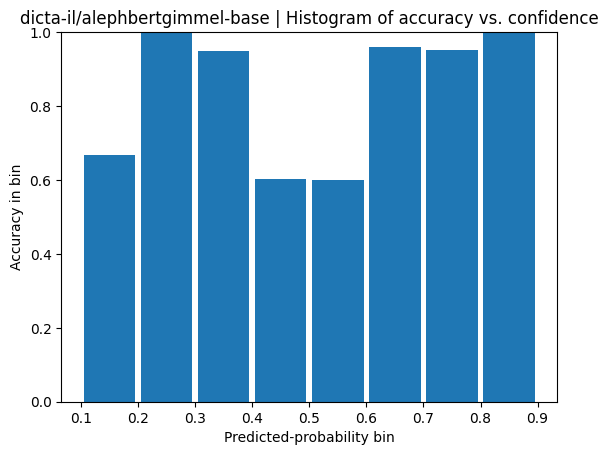

❌  A few errors ---------------------------


,sentence,expression,gold,pred,correct
2,היא נפלה מהכיסא כשגילתה את המחיר המופרך של העוף.,נפל מהכיסא,1,0,False
3,הילד נפל מהכיסא כששמע את השמועה על עצמו שכל חב...,נפל מהכיסא,1,0,False
6,הוא נפל מהכיסא מרוב מבוכה על המקרה המטורף ברחוב.,נפל מהכיסא,1,0,False
11,היא נפלה מהכיסא כשראתה מי הגיע למסיבה בהפתעה א...,נפל מהכיסא,1,0,False
13,כולנו נפלנו מהכיסא כשראינו את התוצאה הסופית של...,נפל מהכיסא,1,0,False
28,הוא נפל מהכיסא כשניסה להגיע למשהו גבוה.,נפל מהכיסא,0,1,False
44,המורה הרימה ידיים מהכיתה הרועשת והפסיקה לנסות ...,הרים ידיים,1,0,False
48,הוא הרים ידיים כדי להשתתף בחידון בכיתה.,הרים ידיים,0,1,False
50,החייל הרים ידיים כהוראת הכניעה בתרגיל הצבאי.,הרים ידיים,0,1,False
54,הוא הרים ידיים כדי לסמן שימסרו לו את הכדור באמ...,הרים ידיים,0,1,False



✅  A few correct predictions --------------


,sentence,expression,gold,pred,correct
0,"נפלתי מהכיסא ממה שהוא אמר לי באמצע השיעור, לא ...",נפל מהכיסא,1,1,True
1,כולם נפלו מהכיסא כששמעו את התוצאה בבחינה הקשה.,נפל מהכיסא,1,1,True
4,הם נפלו מהכיסאות כשגילו מי באמת עומד מאחורי הג...,נפל מהכיסא,1,1,True
5,הבדיחה שהוא סיפר הייתה כל כך טובה שפשוט נפלתי ...,נפל מהכיסא,1,1,True
7,חברי הקבוצה נפלו מהכיסא כשראו את הציונים בפרוי...,נפל מהכיסא,1,1,True
8,אני נופל מהכיסא כל פעם מחדש מהתגובות שלך.,נפל מהכיסא,1,1,True
9,התגובה שלה להצעת הנישואין הפילה אותו מהכיסא.,נפל מהכיסא,1,1,True
10,נפלתי מהכיסא כשקראתי את ההודעה ששלחת בקבוצה של...,נפל מהכיסא,1,1,True
12,הוא נפל מהכיסא כששמע שקיבלו אותו למשרה הבכירה ...,נפל מהכיסא,1,1,True
14,נפלתי מהכיסא כשראיתי את התגובה שלה בתקשורת.,נפל מהכיסא,1,1,True


In [40]:
runner_frozen_gimmel = IdiomExperiment("dicta-il/alephbertgimmel-base", "alephgimmel_frozen_idiom")

# 1️⃣ Setup
runner_frozen_gimmel.setup()

# 2️⃣ Optuna hyperparameter search with frozen encoder
runner_frozen_gimmel.run_optuna_frozen()

# 3️⃣ Train final model (frozen encoder)
runner_frozen_gimmel.train_final_frozen_model()

# 4️⃣ Evaluate everything on frozen model
runner_frozen_gimmel.evaluate_all_frozen(df_test)


## mBERT (Multilingual BERT)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Parameter 'function'=<function IdiomExperiment.setup.<locals>.tokenize_function at 0x7606810511c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

/tmp/ipykernel_528/1121091033.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-07 10:26:33,653] A new study created in memory with name: no-name-e9fb7d53-60a3-4121-adae-8fd787fcabe4
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.512800,0.524740,0.809524,0.805556
2,0.430800,0.705950,0.776190,0.768196
3,0.285100,0.539510,0.847619,0.847120
4,0.276300,0.541067,0.847619,0.847120
5,0.214800,0.536406,0.866667,0.866071


[I 2025-08-07 10:27:11,372] Trial 0 finished with value: 0.8660714285714286 and parameters: {'learning_rate': 1e-05, 'warmup_ratio': 0.22389247791710873, 'per_device_train_batch_size': 8, 'weight_decay': 0.05, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.8660714285714286.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.678200,0.673166,0.585714,0.499877
2,0.614200,0.611795,0.771429,0.760933
3,0.533900,0.553397,0.790476,0.784132
4,0.512400,0.524135,0.800000,0.796887
5,0.461600,0.520384,0.795238,0.792294


[I 2025-08-07 10:27:48,834] Trial 1 finished with value: 0.7922944220816561 and parameters: {'learning_rate': 1e-06, 'warmup_ratio': 0.00976148161736815, 'per_device_train_batch_size': 8, 'weight_decay': 0.0, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.8660714285714286.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.549900,0.550704,0.800000,0.799345
2,0.421100,0.626465,0.819048,0.817391
3,0.324800,0.541869,0.809524,0.806076
4,0.266300,0.578554,0.838095,0.837150
5,0.217700,0.593037,0.842857,0.841560


[I 2025-08-07 10:28:14,678] Trial 2 finished with value: 0.8415601636983012 and parameters: {'learning_rate': 5e-05, 'warmup_ratio': 0.08334071387725359, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8660714285714286.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.548600,0.774032,0.666667,0.627622
2,0.324900,0.562711,0.823810,0.823132
3,0.338300,0.620115,0.819048,0.815772
4,0.303300,0.584683,0.828571,0.826303
5,0.239300,0.588857,0.828571,0.826303


[I 2025-08-07 10:28:41,183] Trial 3 finished with value: 0.8263027295285359 and parameters: {'learning_rate': 1e-05, 'warmup_ratio': 0.021062465303386645, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'label_smoothing_factor': 0.2, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8660714285714286.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.597900,0.634063,0.747619,0.731801
2,0.367000,0.572143,0.814286,0.812031
3,0.323800,0.598914,0.819048,0.816231
4,0.296700,0.567094,0.823810,0.821277
5,0.244800,0.612147,0.833333,0.831310


[I 2025-08-07 10:29:07,676] Trial 4 finished with value: 0.8313098161621262 and parameters: {'learning_rate': 1e-05, 'warmup_ratio': 0.06931470849028233, 'per_device_train_batch_size': 16, 'weight_decay': 0.05, 'label_smoothing_factor': 0.2, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.8660714285714286.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.693400,0.687140,0.509524,0.383321


[I 2025-08-07 10:29:13,409] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.540000,0.566723,0.780952,0.776389


[I 2025-08-07 10:29:23,719] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.567900,0.520562,0.795238,0.794450


[I 2025-08-07 10:29:33,986] Trial 7 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.688500,0.685428,0.533333,0.403409


[I 2025-08-07 10:29:44,347] Trial 8 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.656300,0.549930,0.780952,0.773537
2,0.361800,0.548036,0.809524,0.806559


[I 2025-08-07 10:29:55,219] Trial 9 pruned. 
/tmp/ipykernel_528/1121091033.py:151: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔎 Best run: BestRun(run_id='0', objective=0.8660714285714286, hyperparameters={'learning_rate': 1e-05, 'warmup_ratio': 0.22389247791710873, 'per_device_train_batch_size': 8, 'weight_decay': 0.05, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'linear'}, run_summary=None)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.480900,0.453465,0.804762,0.802391
2,0.454000,0.694878,0.814286,0.813061
3,0.351200,0.763787,0.833333,0.831310
4,0.207000,0.712142,0.852381,0.851624
5,0.023700,0.731784,0.857143,0.856675


/tmp/ipykernel_528/1121091033.py:198: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Test metrics: {'test_loss': 0.5569896697998047, 'test_model_preparation_time': 0.0033, 'test_runtime': 0.4175, 'test_samples_per_second': 503.032, 'test_steps_per_second': 64.675}
              precision    recall  f1-score   support

     literal       0.86      0.91      0.88       105
  figurative       0.91      0.85      0.88       105

    accuracy                           0.88       210
   macro avg       0.88      0.88      0.88       210
weighted avg       0.88      0.88      0.88       210

CM
 [[96  9]
 [16 89]]


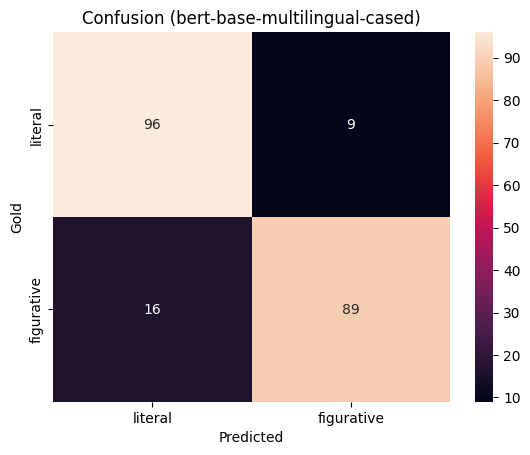

/tmp/ipykernel_528/1121091033.py:231: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(



How many correct?
correct
True     185
False     25
Name: count, dtype: int64 



/tmp/ipykernel_528/1121091033.py:262: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


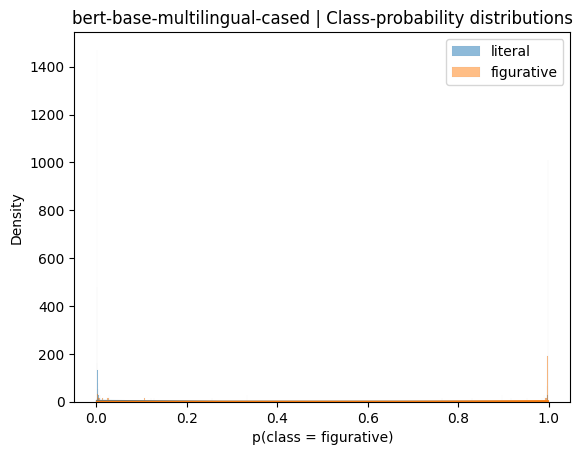

/tmp/ipykernel_528/1121091033.py:290: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


AUC-ROC: 0.9479
Average Precision (AUPRC): 0.9412


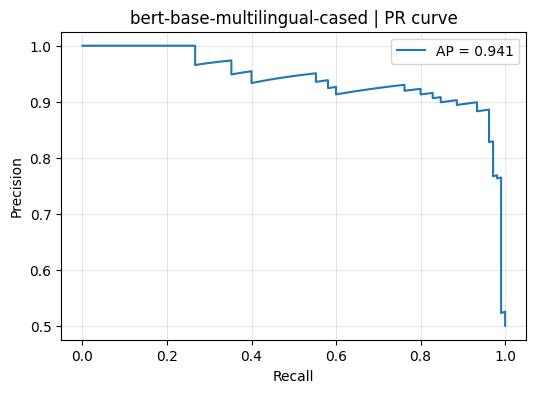

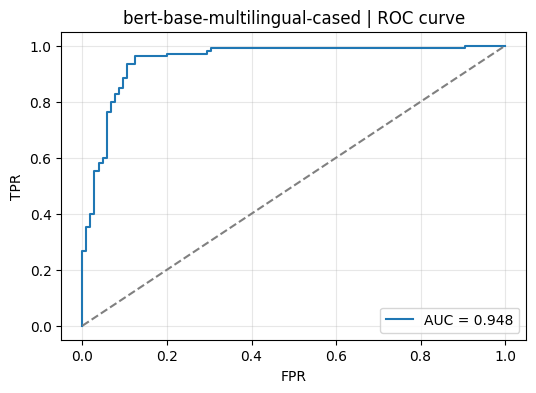

/tmp/ipykernel_528/1121091033.py:332: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Best F1=0.911 at threshold=0.01


/tmp/ipykernel_528/1121091033.py:362: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Brier score: 0.1124 (↓ better, perfect = 0)


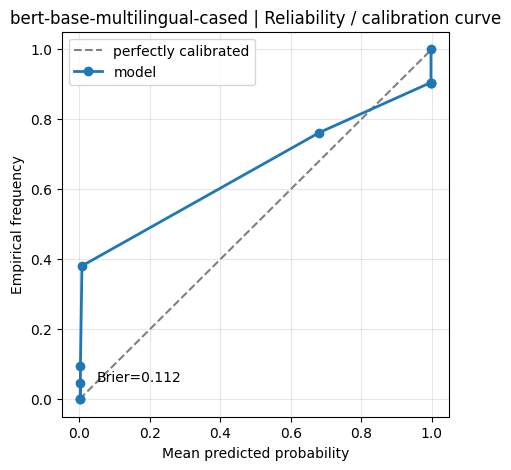

/tmp/ipykernel_528/1121091033.py:398: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


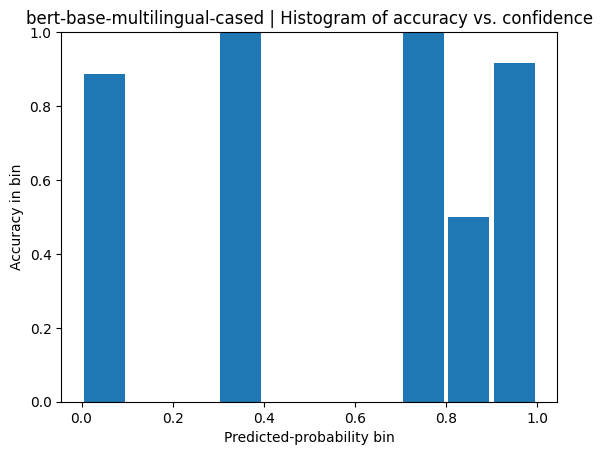

❌  A few errors ---------------------------


,sentence,expression,gold,pred,correct
2,היא נפלה מהכיסא כשגילתה את המחיר המופרך של העוף.,נפל מהכיסא,1,0,False
6,הוא נפל מהכיסא מרוב מבוכה על המקרה המטורף ברחוב.,נפל מהכיסא,1,0,False
13,כולנו נפלנו מהכיסא כשראינו את התוצאה הסופית של...,נפל מהכיסא,1,0,False
36,הרמנו ידיים כשלא הצלחנו למצוא פתרון למבחן הקשה.,הרים ידיים,1,0,False
45,הילד הרים ידיים בהתלהבות כששמע שהוא עולה שלב ב...,הרים ידיים,0,1,False
55,כל התלמידים הרימו ידיים לשאלה של המורה בכיתה.,הרים ידיים,0,1,False
59,כולם הרימו ידיים כאות תמיכה במחאה נגד רשויות ה...,הרים ידיים,0,1,False
60,הקבלן חתך פינה במהלך עבודות השיפוץ וגרם לנזק ר...,חתך פינה,1,0,False
66,כל מי שחותך פינה בסוף משלם ביוקר.,חתך פינה,1,0,False
69,אסור לחתוך פינות כשמדובר בבטיחות.,חתך פינה,1,0,False



✅  A few correct predictions --------------


,sentence,expression,gold,pred,correct
0,"נפלתי מהכיסא ממה שהוא אמר לי באמצע השיעור, לא ...",נפל מהכיסא,1,1,True
1,כולם נפלו מהכיסא כששמעו את התוצאה בבחינה הקשה.,נפל מהכיסא,1,1,True
3,הילד נפל מהכיסא כששמע את השמועה על עצמו שכל חב...,נפל מהכיסא,1,1,True
4,הם נפלו מהכיסאות כשגילו מי באמת עומד מאחורי הג...,נפל מהכיסא,1,1,True
5,הבדיחה שהוא סיפר הייתה כל כך טובה שפשוט נפלתי ...,נפל מהכיסא,1,1,True
7,חברי הקבוצה נפלו מהכיסא כשראו את הציונים בפרוי...,נפל מהכיסא,1,1,True
8,אני נופל מהכיסא כל פעם מחדש מהתגובות שלך.,נפל מהכיסא,1,1,True
9,התגובה שלה להצעת הנישואין הפילה אותו מהכיסא.,נפל מהכיסא,1,1,True
10,נפלתי מהכיסא כשקראתי את ההודעה ששלחת בקבוצה של...,נפל מהכיסא,1,1,True
11,היא נפלה מהכיסא כשראתה מי הגיע למסיבה בהפתעה א...,נפל מהכיסא,1,1,True


In [38]:
runner_mbert = IdiomExperiment("bert-base-multilingual-cased", "mBERT_idiom_full")
runner_mbert.setup()
runner_mbert.run_optuna()
runner_mbert.train_final_model()
runner_mbert.evaluate_on_test()
runner_mbert.attach_predictions(df_test)
runner_mbert.plot_probability_histogram()
runner_mbert.plot_pr_roc_curves()
runner_mbert.find_best_f1_threshold()
runner_mbert.plot_calibration_curve()
runner_mbert.plot_accuracy_vs_confidence()
runner_mbert.inspect_errors(df_test)

## DictaBERT

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

/tmp/ipykernel_93/1121091033.py:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-10 19:28:36,849] A new study created in memory with name: no-name-9adf08c7-ca9b-4901-b5e3-d7e8466b9904
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.644200,0.513770,0.842857,0.841560
2,0.297700,0.473602,0.866667,0.866071
3,0.245200,0.513880,0.861905,0.860994
4,0.222700,0.480812,0.871429,0.870934
5,0.212000,0.496104,0.866667,0.866071


[I 2025-08-10 19:28:56,881] Trial 0 finished with value: 0.8660714285714286 and parameters: {'learning_rate': 1e-05, 'warmup_ratio': 0.22408565751976706, 'per_device_train_batch_size': 16, 'weight_decay': 0.05, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8660714285714286.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.676400,0.669312,0.676190,0.659870
2,0.613400,0.614934,0.828571,0.827002
3,0.532900,0.549707,0.842857,0.841821
4,0.479100,0.508658,0.842857,0.841821
5,0.432300,0.496032,0.852381,0.851624


[I 2025-08-10 19:29:32,414] Trial 1 finished with value: 0.8516239316239316 and parameters: {'learning_rate': 1e-06, 'warmup_ratio': 0.15686587953741934, 'per_device_train_batch_size': 8, 'weight_decay': 0.01, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'linear'}. Best is trial 0 with value: 0.8660714285714286.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.464000,0.500744,0.833333,0.833148
2,0.266300,0.650053,0.804762,0.797788
3,0.238300,0.518977,0.861905,0.861525
4,0.212000,0.531673,0.861905,0.861374
5,0.198900,0.529765,0.861905,0.861374


[I 2025-08-10 19:30:08,113] Trial 2 finished with value: 0.8613735175616307 and parameters: {'learning_rate': 5e-05, 'warmup_ratio': 0.11012418157794876, 'per_device_train_batch_size': 8, 'weight_decay': 0.05, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8660714285714286.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.595800,0.467810,0.847619,0.846224
2,0.255500,0.469847,0.861905,0.861197
3,0.231400,0.514017,0.852381,0.851163
4,0.210300,0.488401,0.866667,0.866230
5,0.209500,0.498077,0.866667,0.866071


[I 2025-08-10 19:30:26,978] Trial 3 finished with value: 0.8660714285714286 and parameters: {'learning_rate': 1e-05, 'warmup_ratio': 0.13516899868525037, 'per_device_train_batch_size': 16, 'weight_decay': 0.0, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8660714285714286.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.416300,0.491045,0.842857,0.841270
2,0.230400,0.472837,0.866667,0.866230
3,0.260800,0.531267,0.847619,0.845928
4,0.221400,0.491873,0.861905,0.861374
5,0.199600,0.496908,0.861905,0.861374


[I 2025-08-10 19:31:02,491] Trial 4 finished with value: 0.8613735175616307 and parameters: {'learning_rate': 1e-05, 'warmup_ratio': 0.18257408489551474, 'per_device_train_batch_size': 8, 'weight_decay': 0.01, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8660714285714286.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.484000,0.473761,0.842857,0.841270
2,0.251300,0.498591,0.857143,0.856505


[I 2025-08-10 19:31:14,183] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.650900,0.535339,0.847619,0.846491
2,0.315100,0.470085,0.861905,0.861374
3,0.253300,0.525300,0.842857,0.840949
4,0.224900,0.476511,0.871429,0.870934
5,0.210000,0.490752,0.866667,0.866071


[I 2025-08-10 19:31:30,667] Trial 6 finished with value: 0.8660714285714286 and parameters: {'learning_rate': 1e-05, 'warmup_ratio': 0.2545371978416597, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8660714285714286.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.657300,0.558969,0.847619,0.846491
2,0.320000,0.478156,0.861905,0.861374
3,0.248800,0.552111,0.828571,0.825903
4,0.223200,0.478474,0.871429,0.870934
5,0.210300,0.488485,0.866667,0.866071


[I 2025-08-10 19:31:47,069] Trial 7 finished with value: 0.8660714285714286 and parameters: {'learning_rate': 1e-05, 'warmup_ratio': 0.28667644549199534, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'label_smoothing_factor': 0.2, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8660714285714286.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.403500,0.468175,0.847619,0.846224


[I 2025-08-10 19:31:53,170] Trial 8 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.383000,0.449994,0.857143,0.856675
2,0.259700,0.471718,0.876190,0.875468
3,0.243500,0.496854,0.861905,0.861374
4,0.210800,0.506494,0.866667,0.865888
5,0.207700,0.510172,0.866667,0.866071


[I 2025-08-10 19:32:08,976] Trial 9 finished with value: 0.8660714285714286 and parameters: {'learning_rate': 5e-05, 'warmup_ratio': 0.18978073521702413, 'per_device_train_batch_size': 16, 'weight_decay': 0.0, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8660714285714286.
/tmp/ipykernel_93/1121091033.py:151: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔎 Best run: BestRun(run_id='0', objective=0.8660714285714286, hyperparameters={'learning_rate': 1e-05, 'warmup_ratio': 0.22408565751976706, 'per_device_train_batch_size': 16, 'weight_decay': 0.05, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'cosine'}, run_summary=None)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.644200,0.513770,0.842857,0.841560
2,0.297700,0.473602,0.866667,0.866071
3,0.245200,0.513880,0.861905,0.860994
4,0.222700,0.480812,0.871429,0.870934
5,0.212000,0.496104,0.866667,0.866071


/tmp/ipykernel_93/1121091033.py:198: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Test metrics: {'test_loss': 0.15471979975700378, 'test_model_preparation_time': 0.0027, 'test_runtime': 0.2398, 'test_samples_per_second': 875.787, 'test_steps_per_second': 112.601}
              precision    recall  f1-score   support

     literal       0.96      0.96      0.96       105
  figurative       0.96      0.96      0.96       105

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210

CM
 [[101   4]
 [  4 101]]


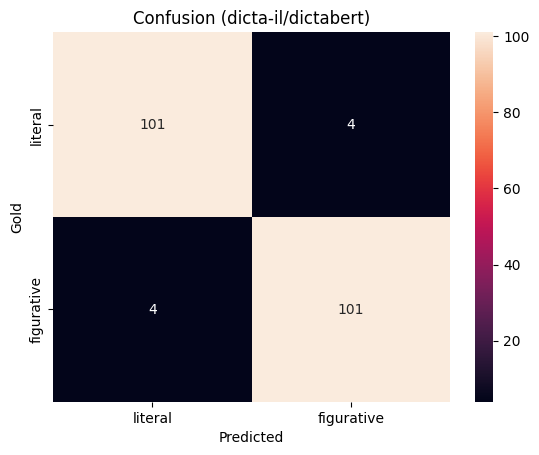

/tmp/ipykernel_93/1121091033.py:231: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(



How many correct?
correct
True     202
False      8
Name: count, dtype: int64 



/tmp/ipykernel_93/1121091033.py:262: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


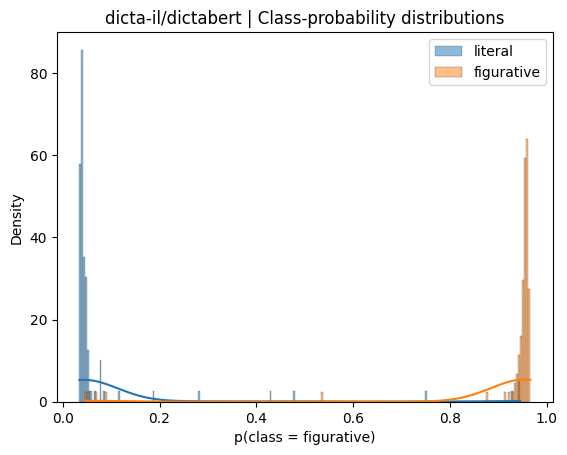

/tmp/ipykernel_93/1121091033.py:290: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


AUC-ROC: 0.9902
Average Precision (AUPRC): 0.9913


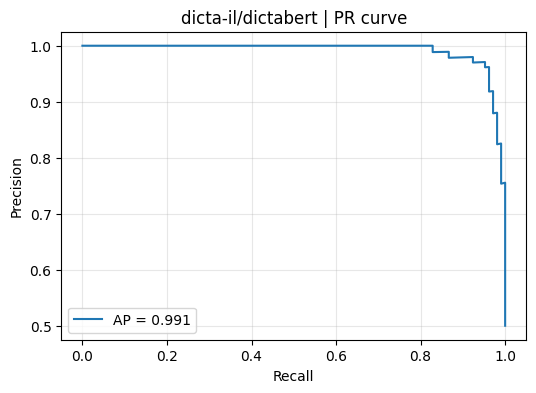

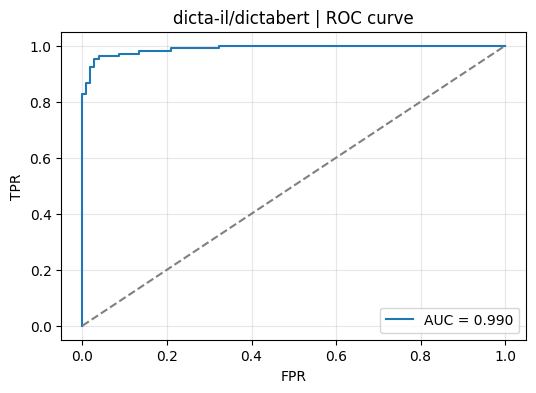

/tmp/ipykernel_93/1121091033.py:332: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Best F1=0.962 at threshold=0.48


/tmp/ipykernel_93/1121091033.py:362: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Brier score: 0.0376 (↓ better, perfect = 0)


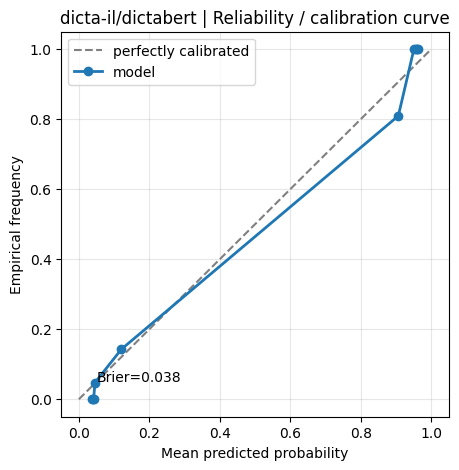

/tmp/ipykernel_93/1121091033.py:398: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


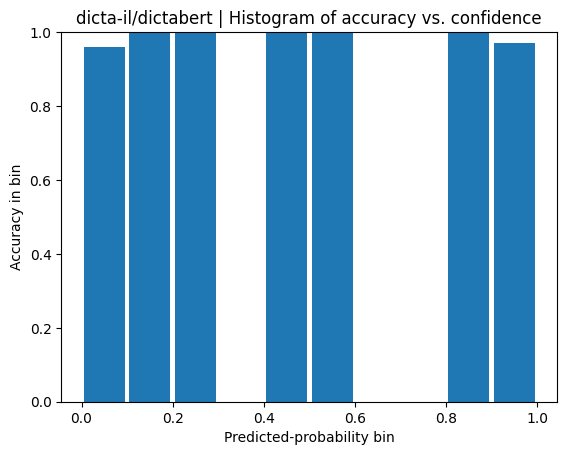

❌  A few errors ---------------------------


,sentence,expression,gold,pred,correct
44,המורה הרימה ידיים מהכיתה הרועשת והפסיקה לנסות ...,הרים ידיים,1,0,False
45,הילד הרים ידיים בהתלהבות כששמע שהוא עולה שלב ב...,הרים ידיים,0,1,False
55,כל התלמידים הרימו ידיים לשאלה של המורה בכיתה.,הרים ידיים,0,1,False
59,כולם הרימו ידיים כאות תמיכה במחאה נגד רשויות ה...,הרים ידיים,0,1,False
60,הקבלן חתך פינה במהלך עבודות השיפוץ וגרם לנזק ר...,חתך פינה,1,0,False
67,היא חתכה פינה בזמן הכנת העבודת גמר כדי להגיש ב...,חתך פינה,1,0,False
73,המהנדס חתך פינה בתכנון והמבנה יצא לא יציב.,חתך פינה,1,0,False
113,היא הלכה בין הטיפות בדרך הביתה מהלימודים.,הלך בין טיפות,0,1,False



✅  A few correct predictions --------------


,sentence,expression,gold,pred,correct
0,"נפלתי מהכיסא ממה שהוא אמר לי באמצע השיעור, לא ...",נפל מהכיסא,1,1,True
1,כולם נפלו מהכיסא כששמעו את התוצאה בבחינה הקשה.,נפל מהכיסא,1,1,True
2,היא נפלה מהכיסא כשגילתה את המחיר המופרך של העוף.,נפל מהכיסא,1,1,True
3,הילד נפל מהכיסא כששמע את השמועה על עצמו שכל חב...,נפל מהכיסא,1,1,True
4,הם נפלו מהכיסאות כשגילו מי באמת עומד מאחורי הג...,נפל מהכיסא,1,1,True
5,הבדיחה שהוא סיפר הייתה כל כך טובה שפשוט נפלתי ...,נפל מהכיסא,1,1,True
6,הוא נפל מהכיסא מרוב מבוכה על המקרה המטורף ברחוב.,נפל מהכיסא,1,1,True
7,חברי הקבוצה נפלו מהכיסא כשראו את הציונים בפרוי...,נפל מהכיסא,1,1,True
8,אני נופל מהכיסא כל פעם מחדש מהתגובות שלך.,נפל מהכיסא,1,1,True
9,התגובה שלה להצעת הנישואין הפילה אותו מהכיסא.,נפל מהכיסא,1,1,True


In [18]:
runner_dictabert = IdiomExperiment("dicta-il/dictabert", "DictaBERT_idiom_full")
runner_dictabert.setup()
runner_dictabert.run_optuna()
runner_dictabert.train_final_model()
runner_dictabert.evaluate_on_test()
runner_dictabert.attach_predictions(df_test)
runner_dictabert.plot_probability_histogram()
runner_dictabert.plot_pr_roc_curves()
runner_dictabert.find_best_f1_threshold()
runner_dictabert.plot_calibration_curve()
runner_dictabert.plot_accuracy_vs_confidence()
runner_dictabert.inspect_errors(df_test)

## Frozen DictaBERT

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

/tmp/ipykernel_1408/1121091033.py:569: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-06 19:11:07,097] A new study created in memory with name: no-name-b5290b97-8867-4434-8117-f219ff7a8380
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.635600,0.576720,0.819048,0.814746
2,0.512300,0.535818,0.795238,0.787924
3,0.472500,0.495156,0.823810,0.822906


[I 2025-08-06 19:11:18,517] Trial 0 finished with value: 0.8229059829059829 and parameters: {'learning_rate': 0.001, 'warmup_ratio': 0.18408937444703685, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'label_smoothing_factor': 0.05, 'lr_scheduler_type': 'cosine'}. Best is trial 0 with value: 0.8229059829059829.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.611700,0.566528,0.842857,0.840216
2,0.514900,0.534419,0.814286,0.808980
3,0.473400,0.495347,0.833333,0.832234


[I 2025-08-06 19:11:29,922] Trial 1 finished with value: 0.8322339138572505 and parameters: {'learning_rate': 0.001, 'warmup_ratio': 0.09294456315462188, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'label_smoothing_factor': 0.05, 'lr_scheduler_type': 'linear'}. Best is trial 1 with value: 0.8322339138572505.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.533800,0.531410,0.804762,0.798507
2,0.441600,0.466242,0.847619,0.846491
3,0.450700,0.458652,0.847619,0.846491


[I 2025-08-06 19:11:47,499] Trial 2 finished with value: 0.8464912280701755 and parameters: {'learning_rate': 0.001, 'warmup_ratio': 0.06083479689598486, 'per_device_train_batch_size': 8, 'weight_decay': 0.01, 'label_smoothing_factor': 0.05, 'lr_scheduler_type': 'cosine'}. Best is trial 2 with value: 0.8464912280701755.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.688300,0.680100,0.638095,0.619855
2,0.673000,0.668935,0.690476,0.678210
3,0.666500,0.665048,0.709524,0.695544


[I 2025-08-06 19:11:58,740] Trial 3 finished with value: 0.6955436720142603 and parameters: {'learning_rate': 0.0001, 'warmup_ratio': 0.047889197505086224, 'per_device_train_batch_size': 16, 'weight_decay': 0.0, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.8464912280701755.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.700200,0.693343,0.509524,0.492003
2,0.696200,0.688939,0.566667,0.547703
3,0.688200,0.688098,0.571429,0.547804


[I 2025-08-06 19:12:07,298] Trial 4 finished with value: 0.5478036175710594 and parameters: {'learning_rate': 5e-05, 'warmup_ratio': 0.15122974989657695, 'per_device_train_batch_size': 32, 'weight_decay': 0.0, 'label_smoothing_factor': 0.1, 'lr_scheduler_type': 'cosine'}. Best is trial 2 with value: 0.8464912280701755.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.689900,0.652046,0.666667,0.637037
2,0.648000,0.613437,0.842857,0.842568
3,0.614200,0.608368,0.823810,0.821277


[I 2025-08-06 19:12:16,070] Trial 5 finished with value: 0.8212765957446808 and parameters: {'learning_rate': 0.0005, 'warmup_ratio': 0.17623746788227368, 'per_device_train_batch_size': 32, 'weight_decay': 0.0, 'label_smoothing_factor': 0.0, 'lr_scheduler_type': 'cosine'}. Best is trial 2 with value: 0.8464912280701755.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.662000,0.602606,0.809524,0.805556
2,0.590300,0.557118,0.833333,0.832479
3,0.555400,0.549848,0.833333,0.830937


[I 2025-08-06 19:12:24,704] Trial 6 finished with value: 0.8309373202990225 and parameters: {'learning_rate': 0.001, 'warmup_ratio': 0.022791823160639615, 'per_device_train_batch_size': 32, 'weight_decay': 0.0, 'label_smoothing_factor': 0.05, 'lr_scheduler_type': 'linear'}. Best is trial 2 with value: 0.8464912280701755.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.681300,0.675392,0.619048,0.577295


[I 2025-08-06 19:12:31,354] Trial 7 pruned. 
/tmp/ipykernel_1408/1121091033.py:637: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔎 Best run (Frozen): BestRun(run_id='2', objective=0.8464912280701755, hyperparameters={'learning_rate': 0.001, 'warmup_ratio': 0.06083479689598486, 'per_device_train_batch_size': 8, 'weight_decay': 0.01, 'label_smoothing_factor': 0.05, 'lr_scheduler_type': 'cosine'}, run_summary=None)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/dictabert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.520600,0.517235,0.800000,0.793230
2,0.417800,0.444553,0.847619,0.846224
3,0.425500,0.432948,0.847619,0.846491


🔹 Evaluating frozen model...



/tmp/ipykernel_1408/1121091033.py:198: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Test metrics: {'test_loss': 0.3483032286167145, 'test_model_preparation_time': 0.0071, 'test_runtime': 0.8539, 'test_samples_per_second': 245.935, 'test_steps_per_second': 31.62}
              precision    recall  f1-score   support

     literal       0.96      0.92      0.94       105
  figurative       0.93      0.96      0.94       105

    accuracy                           0.94       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.94      0.94       210

CM
 [[ 97   8]
 [  4 101]]


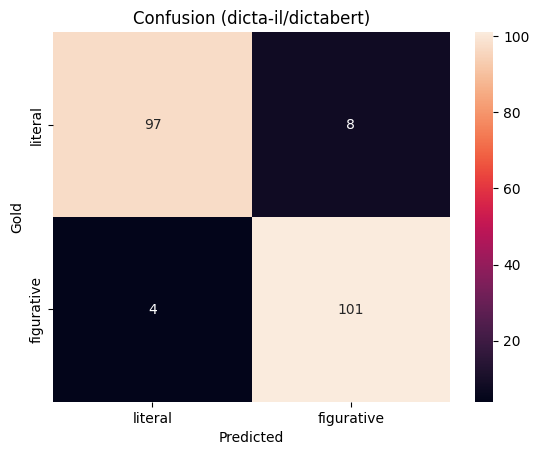

/tmp/ipykernel_1408/1121091033.py:231: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(



How many correct?
correct
True     198
False     12
Name: count, dtype: int64 



/tmp/ipykernel_1408/1121091033.py:262: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


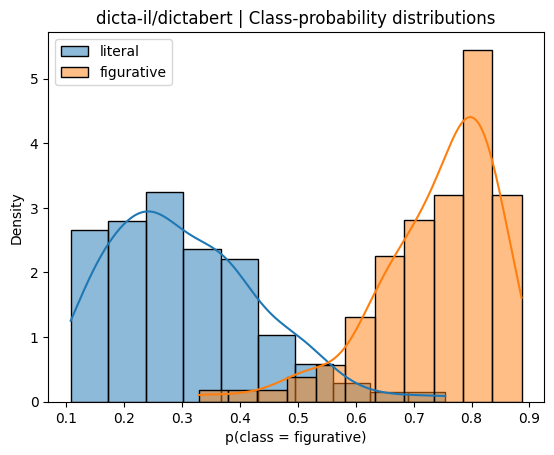

/tmp/ipykernel_1408/1121091033.py:290: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


AUC-ROC: 0.9860
Average Precision (AUPRC): 0.9860


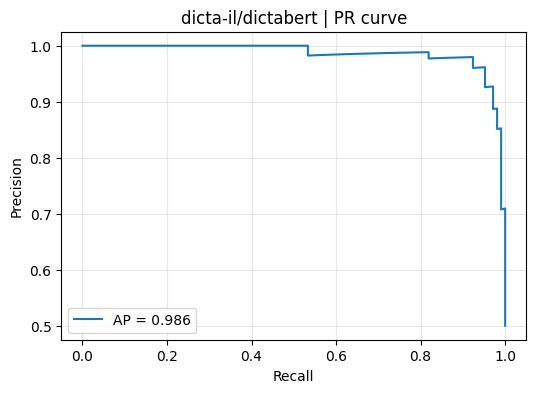

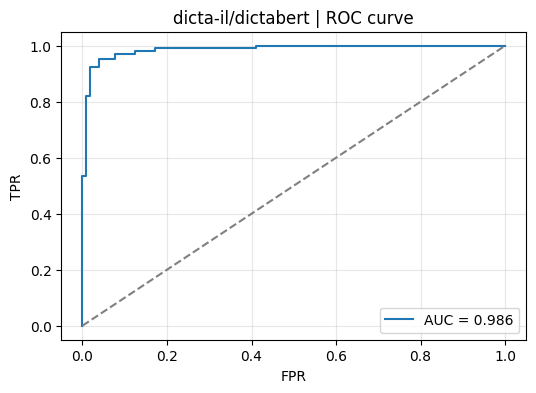

/tmp/ipykernel_1408/1121091033.py:332: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Best F1=0.957 at threshold=0.54


/tmp/ipykernel_1408/1121091033.py:362: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Brier score: 0.0939 (↓ better, perfect = 0)


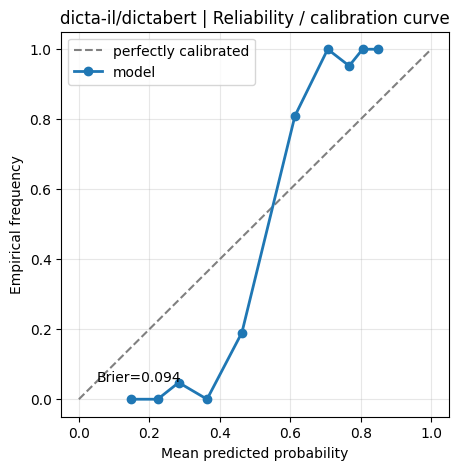

/tmp/ipykernel_1408/1121091033.py:398: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


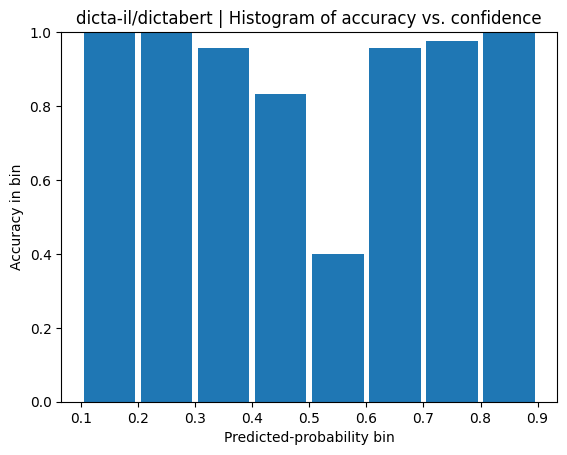

❌  A few errors ---------------------------


,sentence,expression,gold,pred,correct
25,המורה נבהלה מצעקה של תלמידה טובה ונפלה מהכיסא ...,נפל מהכיסא,0,1,False
45,הילד הרים ידיים בהתלהבות כששמע שהוא עולה שלב ב...,הרים ידיים,0,1,False
55,כל התלמידים הרימו ידיים לשאלה של המורה בכיתה.,הרים ידיים,0,1,False
59,כולם הרימו ידיים כאות תמיכה במחאה נגד רשויות ה...,הרים ידיים,0,1,False
60,הקבלן חתך פינה במהלך עבודות השיפוץ וגרם לנזק ר...,חתך פינה,1,0,False
67,היא חתכה פינה בזמן הכנת העבודת גמר כדי להגיש ב...,חתך פינה,1,0,False
73,המהנדס חתך פינה בתכנון והמבנה יצא לא יציב.,חתך פינה,1,0,False
113,היא הלכה בין הטיפות בדרך הביתה מהלימודים.,הלך בין טיפות,0,1,False
129,הילד תפס תחת ולא הסכים להקשיב כשגדל קצת והתבגר.,תפס תחת,1,0,False
140,הוא תפס לעצמו את התחת מרוב כאב אחרי המכה שחטף.,תפס תחת,0,1,False



✅  A few correct predictions --------------


,sentence,expression,gold,pred,correct
0,"נפלתי מהכיסא ממה שהוא אמר לי באמצע השיעור, לא ...",נפל מהכיסא,1,1,True
1,כולם נפלו מהכיסא כששמעו את התוצאה בבחינה הקשה.,נפל מהכיסא,1,1,True
2,היא נפלה מהכיסא כשגילתה את המחיר המופרך של העוף.,נפל מהכיסא,1,1,True
3,הילד נפל מהכיסא כששמע את השמועה על עצמו שכל חב...,נפל מהכיסא,1,1,True
4,הם נפלו מהכיסאות כשגילו מי באמת עומד מאחורי הג...,נפל מהכיסא,1,1,True
5,הבדיחה שהוא סיפר הייתה כל כך טובה שפשוט נפלתי ...,נפל מהכיסא,1,1,True
6,הוא נפל מהכיסא מרוב מבוכה על המקרה המטורף ברחוב.,נפל מהכיסא,1,1,True
7,חברי הקבוצה נפלו מהכיסא כשראו את הציונים בפרוי...,נפל מהכיסא,1,1,True
8,אני נופל מהכיסא כל פעם מחדש מהתגובות שלך.,נפל מהכיסא,1,1,True
9,התגובה שלה להצעת הנישואין הפילה אותו מהכיסא.,נפל מהכיסא,1,1,True


In [41]:
runner_frozen_dictabert = IdiomExperiment("dicta-il/dictabert", "DictaBERT_frozen_idiom")

# 1️⃣ Setup
runner_frozen_dictabert.setup()

# 2️⃣ Optuna hyperparameter search with frozen encoder
runner_frozen_dictabert.run_optuna_frozen()

# 3️⃣ Train final model (frozen encoder)
runner_frozen_dictabert.train_final_frozen_model()

# 4️⃣ Evaluate everything on frozen model
runner_frozen_dictabert.evaluate_all_frozen(df_test)


## Investigation of the Models Behavior

#### Loading our best model

In [19]:
MODEL_FOLDER = Path("AlephBERTGimmel_idiom_full")  # Convert string to Path object
BEST_DIR = MODEL_FOLDER / "best"
LOG_DIR = MODEL_FOLDER / "logs"
RUN_DIR = MODEL_FOLDER

In [20]:
# ======================================================
# 1.  Tokeniser  (uses the AlephBERT vocab)
# ======================================================
tokenizer = AutoTokenizer.from_pretrained(str(BEST_DIR))

def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, max_length=64)

tokenised_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["sentence", "expression"],
)
tokenised_datasets.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)
data_collator = DataCollatorWithPadding(tokenizer)


Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

/tmp/ipykernel_528/2950872918.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_tr_Aleph = Trainer(


Test metrics: {'test_loss': 0.19649314880371094, 'test_model_preparation_time': 0.0034, 'test_runtime': 0.4149, 'test_samples_per_second': 506.157, 'test_steps_per_second': 65.077}
              precision    recall  f1-score   support

     literal       0.96      0.92      0.94       105
  figurative       0.93      0.96      0.94       105

    accuracy                           0.94       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.94      0.94       210

Confusion Matrix:
 [[ 97   8]
 [  4 101]]


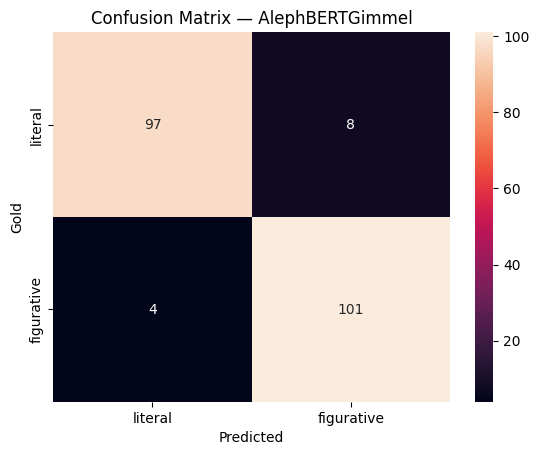

In [21]:
# ======================================================
# 7.  Final test-set evaluation using the best weights
# ======================================================
best_model_Aleph = AutoModelForSequenceClassification.from_pretrained(
    str(BEST_DIR)
).to(device).eval()

eval_tr_Aleph = Trainer(
    model=best_model_Aleph,
    args=TrainingArguments(output_dir="/tmp/eval", do_train=False, report_to=[]),
    tokenizer=tokenizer,
    data_collator=data_collator
)

# 6. Evaluate
test_out_Aleph = eval_tr_Aleph.predict(tokenised_datasets["test"])
logits_aleph   = test_out_Aleph.predictions
labels_aleph   = test_out_Aleph.label_ids
preds_aleph    = np.argmax(logits_aleph, axis=-1)
probs_aleph    = torch.softmax(torch.tensor(logits_aleph), dim=-1)[:, 1].numpy()

# 7. Print and plot results
print("Test metrics:", test_out_Aleph.metrics)
print(classification_report(labels_aleph, preds_aleph, target_names=["literal", "figurative"]))
print("Confusion Matrix:\n", confusion_matrix(labels_aleph, preds_aleph))

cm_aleph = confusion_matrix(labels_aleph, preds_aleph)
sns.heatmap(cm_aleph, annot=True, fmt="d",
            xticklabels=["literal", "figurative"],
            yticklabels=["literal", "figurative"])
plt.ylabel("Gold"); plt.xlabel("Predicted")
plt.title("Confusion Matrix — AlephBERTGimmel")
plt.show()

In [22]:
# ======================================================
# 8.  (Optional) Attach predictions to df_test & save
# ======================================================
# Step 1: Make a copy of the original df_test (which has sentences)
df_test_text = df_test.copy()          # <-- safe to mutate
df_test_text["pred"]    = preds_aleph
df_test_text["gold"]    = labels_aleph
df_test_text["correct"] = df_test_text["pred"] == df_test_text["gold"]

# sanity
print(df_test_text.columns)   # should include 'sentence'
print("\nCorrect / incorrect counts:")
print(df_test_text["correct"].value_counts())

Index(['expression', 'sentence', 'labels', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'pred', 'gold', 'correct'],
      dtype='object')

Correct / incorrect counts:
correct
True     198
False     12
Name: count, dtype: int64


#### Loading Some samples to sample from
- false posisitve
- false negative
- true figurative
- true litural

In [23]:
false_pos = df_test_text[(df_test_text.gold == 0) & (df_test_text.pred == 1)]
false_neg = df_test_text[(df_test_text.gold == 1) & (df_test_text.pred == 0)]
true_figurative = df_test_text[(df_test_text.gold == 1) & (df_test_text.pred == 1)]
true_litural = df_test_text[(df_test_text.gold == 0) & (df_test_text.pred == 0)]


print(f"False-positives: {len(false_pos)},  False-negatives: {len(false_neg)}")

False-positives: 8,  False-negatives: 4


#### Initializing SequenceClassificationExplainer

In [24]:
# Use AlephBERT model and tokenizer (already loaded)
explainer = SequenceClassificationExplainer(
    model=best_model_Aleph,
    tokenizer=tokenizer
)

### Running the explainer of the sentence and vizualize

In [25]:
example_sentence = false_pos.iloc[2]["sentence"]    # or .iloc[n]
print(example_sentence)

הוא הרים ידיים כדי להשתתף בחידון בכיתה.


In [26]:
word_attributions = explainer(example_sentence, index=0)

# Print attribution score per token
for word, score in word_attributions:
    print(f"{word}: {score:.4f}")


explainer.visualize()

[CLS]: 0.0000
הוא: 0.1260
הרים: -0.3597
ידיים: -0.8495
כדי: -0.0222
להשתתף: -0.1815
בחידון: -0.2634
בכיתה: 0.0860
.: 0.1512
[SEP]: 0.0000


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_1 (0.36),LABEL_0,-1.31,[CLS] הוא הרים ידיים כדי להשתתף בחידון בכיתה . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_1 (0.36),LABEL_0,-1.31,[CLS] הוא הרים ידיים כדי להשתתף בחידון בכיתה . [SEP]


In [27]:
example_sentence_2 = false_neg.iloc[2]["sentence"]    # or .iloc[n]
print(example_sentence_2)

המהנדס חתך פינה בתכנון והמבנה יצא לא יציב.


In [28]:
word_attributions_2 = explainer(example_sentence_2, index=1)

# Print attribution score per token
for word, score in word_attributions_2:
    print(f"{word}: {score:.4f}")


explainer.visualize()

[CLS]: 0.0000
המהנדס: -0.4625
חתך: -0.2695
פינה: -0.2196
בתכנון: 0.0041
והמבנה: -0.0330
יצא: -0.1025
לא: -0.2213
יציב: -0.6976
.: 0.3435
[SEP]: 0.0000


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_0 (0.09),LABEL_1,-1.66,[CLS] המהנדס חתך פינה בתכנון והמבנה יצא לא יציב . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_0 (0.09),LABEL_1,-1.66,[CLS] המהנדס חתך פינה בתכנון והמבנה יצא לא יציב . [SEP]


In [29]:
example_sentence_3 = true_figurative.iloc[53]["sentence"]    # or .iloc[n]
print(example_sentence_3)

היא יודעת להתחמק מביקורת ותמיד הולכת בין הטיפות כמו אמנית.


In [30]:
word_attributions_3 = explainer(example_sentence_3, index=1)

# Print attribution score per token
for word, score in word_attributions_3:
    print(f"{word}: {score:.4f}")


explainer.visualize()

[CLS]: 0.0000
היא: 0.0827
יודעת: 0.4751
להתחמק: 0.1157
מביקורת: 0.6520
ותמיד: -0.0465
הולכת: 0.3390
בין: -0.3407
הטיפות: -0.0974
כמו: -0.2828
אמנית: -0.0794
.: 0.0049
[SEP]: 0.0000


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.90),LABEL_1,0.82,[CLS] היא יודעת להתחמק מביקורת ותמיד הולכת בין הטיפות כמו אמנית . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.90),LABEL_1,0.82,[CLS] היא יודעת להתחמק מביקורת ותמיד הולכת בין הטיפות כמו אמנית . [SEP]


In [31]:
example_sentence_4 = true_litural.iloc[0]["sentence"]    # or .iloc[n]
print(example_sentence_4)

הילד קפץ בזמן הישיבה ונפל מהכיסא על הרצפה.


In [32]:
word_attributions_4 = explainer(example_sentence_4, index=0)

# Print attribution score per token
for word, score in word_attributions_4:
    print(f"{word}: {score:.4f}")


explainer.visualize()

[CLS]: 0.0000
הילד: 0.5467
קפץ: 0.1573
בזמן: 0.3648
הישיבה: 0.1282
ונפל: 0.1906
מהכיסא: 0.2116
על: 0.2474
הרצפה: 0.5960
.: 0.1710
[SEP]: 0.0000


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.91),LABEL_0,2.61,[CLS] הילד קפץ בזמן הישיבה ונפל מהכיסא על הרצפה . [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.91),LABEL_0,2.61,[CLS] הילד קפץ בזמן הישיבה ונפל מהכיסא על הרצפה . [SEP]


### Attention heatmaps for our model

In [33]:
# ──────────────────────────────────────────────────
# 1.  Reload model with attentions enabled
# ──────────────────────────────────────────────────
best_model_Aleph_attn = AutoModelForSequenceClassification.from_pretrained(
    str(BEST_DIR),
    output_attentions=True          # <-- this is the key flag
).to(device).eval()

In [34]:
# ──────────────────────────────────────────────────
# 3.  Forward pass to get attentions
# ──────────────────────────────────────────────────
enc = tokenizer(example_sentence, return_tensors="pt").to(device)
with torch.no_grad():
    out = best_model_Aleph_attn(**enc)

# out.attentions is a tuple: (num_layers, batch=1, num_heads, seq_len, seq_len)
all_attn = out.attentions                       # list of tensors

last_layer_attn = all_attn[-1].squeeze(0)       # (heads, seq, seq)
# We’ll average across heads and focus on CLS-to-token weights
cls_to_tokens = last_layer_attn[:, 0, :]        # (heads, seq)
cls_attn = cls_to_tokens.mean(dim=0).cpu().numpy()  # (seq,)


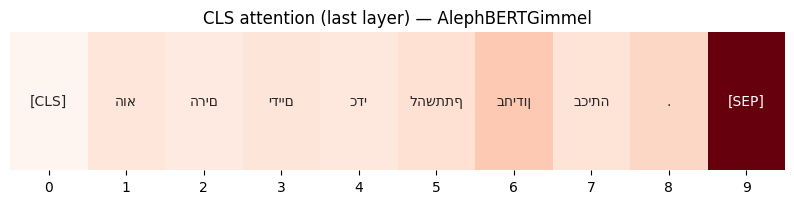

In [35]:
# ──────────────────────────────────────────────────
# 4.  Plot
# ──────────────────────────────────────────────────
tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])
plt.figure(figsize=(10, 1.8))
sns.heatmap(cls_attn[None, :],
            annot=np.array(tokens)[None, :],
            fmt="",
            cmap="Reds",
            cbar=False)
plt.yticks([]); plt.title("CLS attention (last layer) — AlephBERTGimmel")
plt.show()

### t-SNE visualization and comparing AlephBERTGimmel and m-BERT

In [41]:
# Fine-tuned model checkpoint folders
ALEPH_DIR = Path("AlephBERTGimmel_idiom_full") / "best"   # best checkpoint folder
MBERT_DIR = Path("mBERT_idiom_full") / "best"             # best checkpoint folder

# Inference parameters
BATCH_SIZE = 64
COL_TEXT   = "sentence"
COL_LABEL  = "labels"  # 0 = literal, 1 = figurative

In [42]:
# ════════════════════════════════════════════════════════════════════════
# 1. Tokenisers + two model pairs  (encoder + classifier)
# ════════════════════════════════════════════════════════════════════════
tok_aleph = AutoTokenizer.from_pretrained(str(ALEPH_DIR))
tok_mbert = AutoTokenizer.from_pretrained(str(MBERT_DIR))

enc_aleph = AutoModel.from_pretrained(str(ALEPH_DIR),
                                      output_hidden_states=False).to(device).eval()
enc_mbert = AutoModel.from_pretrained(str(MBERT_DIR),
                                      output_hidden_states=False).to(device).eval()

cls_aleph = (AutoModelForSequenceClassification
             .from_pretrained(str(ALEPH_DIR)).to(device).eval())
cls_mbert = (AutoModelForSequenceClassification
             .from_pretrained(str(MBERT_DIR)).to(device).eval())


In [43]:
# ════════════════════════════════════════════════════════════════════════
# 2. Generic DataLoader builder
# ════════════════════════════════════════════════════════════════════════
def get_loader(ds, tokenizer, batch_size=BATCH_SIZE):
    def _tok(batch):
        return tokenizer(batch[COL_TEXT], truncation=True, max_length=64)
    ds_tok = ds.map(_tok, batched=True)
    ds_tok.set_format(type="torch",
                      columns=["input_ids", "attention_mask", COL_LABEL])
    return torch.utils.data.DataLoader(
        ds_tok,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=DataCollatorWithPadding(tokenizer),
    )

loader_aleph = get_loader(raw_datasets["test"], tok_aleph)
loader_mbert = get_loader(raw_datasets["test"], tok_mbert)

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

In [44]:
# ════════════════════════════════════════════════════════════════════════
# 3. Helpers
# ════════════════════════════════════════════════════════════════════════
@torch.no_grad()
def cls_embeddings(model_enc, loader):
    vecs, labels = [], []
    for batch in tqdm(loader, desc="Embedding"):
        outs = model_enc(input_ids=batch["input_ids"].to(device),
                         attention_mask=batch["attention_mask"].to(device),
                         return_dict=True)
        vecs.append( outs.last_hidden_state[:, 0, :].cpu() )          # CLS token
        labels.append( batch[COL_LABEL] )
    return torch.cat(vecs).numpy(), torch.cat(labels).numpy()

@torch.no_grad()
def batch_predictions(model_cls, loader):
    logits, labels = [], []
    for batch in loader:
        outs   = model_cls(input_ids=batch["input_ids"].to(device),
                           attention_mask=batch["attention_mask"].to(device),
                           return_dict=True)
        logits.append( outs.logits.cpu() )
        labels.append( batch[COL_LABEL] )
    logits = torch.cat(logits)
    preds  = logits.argmax(dim=-1).numpy()
    labels = torch.cat(labels).numpy()
    return preds, labels

In [45]:
# ════════════════════════════════════════════════════════════════════════
# 4. Collect vectors & predictions
# ════════════════════════════════════════════════════════════════════════
vec_aleph, y_test            = cls_embeddings(enc_aleph, loader_aleph)
vec_mbert, _                 = cls_embeddings(enc_mbert, loader_mbert)

preds_aleph, _               = batch_predictions(cls_aleph, loader_aleph)
preds_mbert, _               = batch_predictions(cls_mbert, loader_mbert)

print("Aleph accuracy:", (preds_aleph == y_test).mean())
print("mBERT accuracy:", (preds_mbert == y_test).mean())

Embedding:   0%|          | 0/4 [00:00<?, ?it/s]

Embedding:   0%|          | 0/4 [00:00<?, ?it/s]

Aleph accuracy: 0.9428571428571428
mBERT accuracy: 0.8809523809523809


In [46]:
# ════════════════════════════════════════════════════════════════════════
# 5. t-SNE (single fit for comparability)
# ════════════════════════════════════════════════════════════════════════
all_vecs   = np.vstack([vec_aleph, vec_mbert])
model_tag  = np.array(["Aleph"] * len(y_test) + ["mBERT"] * len(y_test))
gold       = np.concatenate([y_test, y_test])
preds      = np.concatenate([preds_aleph, preds_mbert])

tsne = TSNE(n_components=2, perplexity=40, metric="cosine",
            init="pca", random_state=42)
xy_2d = tsne.fit_transform(all_vecs)

# turn the HuggingFace column into a Python list first
sent_list = list(raw_datasets["test"][COL_TEXT])      # len = n_test
sent_list = sent_list * 2                             # duplicate for 2 models

df_tsne = (pd.DataFrame(xy_2d, columns=["x", "y"])
             .assign(model   = model_tag,
                     gold    = gold,
                     pred    = preds,
                     correct = lambda d: d.gold == d.pred,
                     sentence = sent_list))

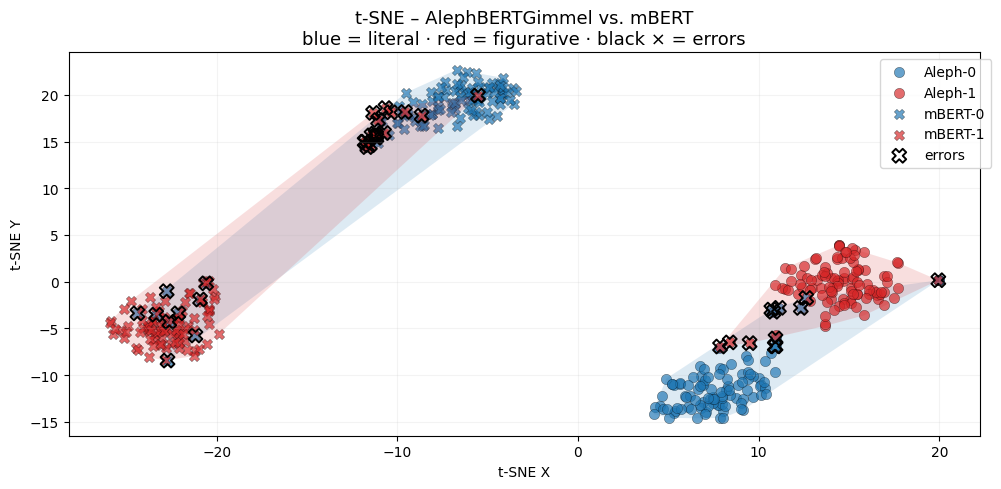

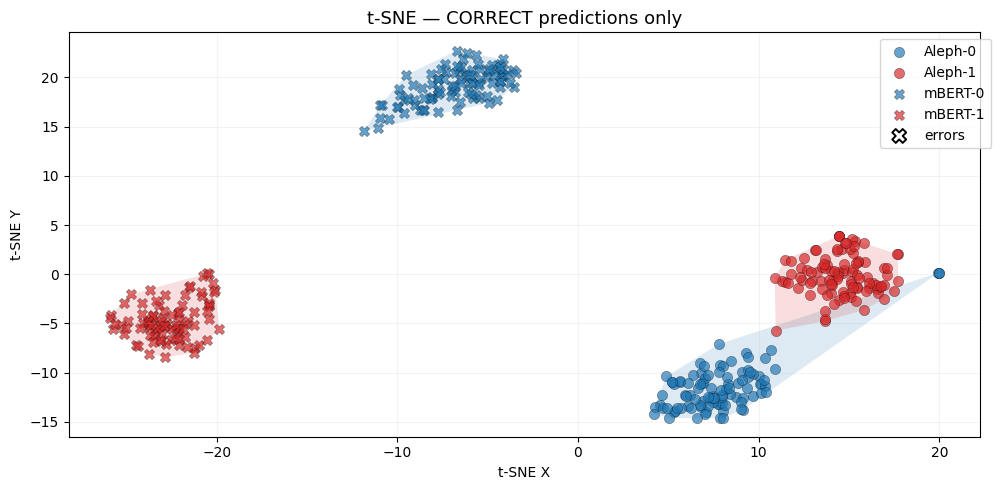

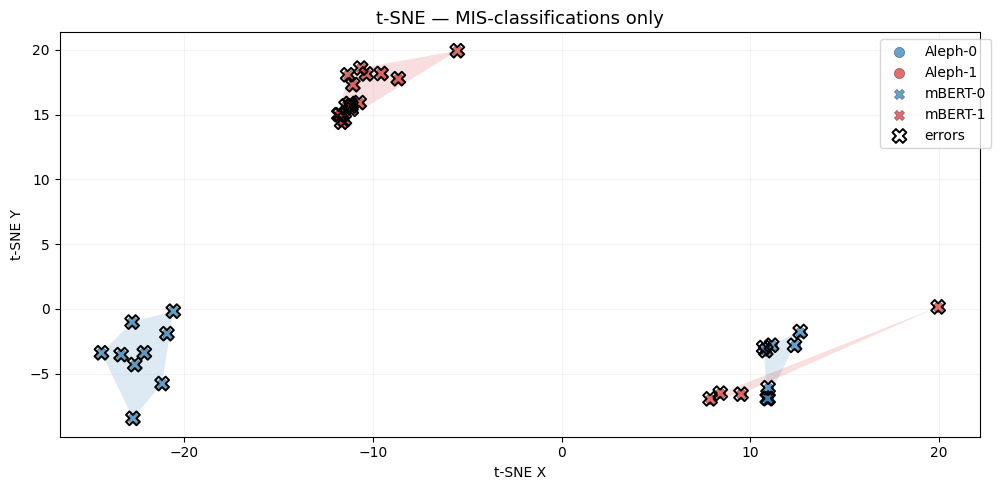

In [47]:
# ════════════════════════════════════════════════════════════════════════
# 6. Helper – convex hull drawer + plotter
# ════════════════════════════════════════════════════════════════════════
from scipy.spatial import ConvexHull

def draw_hull(ax, xs, ys, color, alpha=.15):
    if len(xs) < 3: return
    coords   = np.vstack([xs, ys]).T
    hull     = ConvexHull(coords)
    verts    = coords[hull.vertices]
    ax.fill(*verts.T, color=color, alpha=alpha, linewidth=0)

palette_lbl  = {0:"#1f77b4", 1:"#d62728"}   # literal / figurative
marker_model = {"Aleph":"o",  "mBERT":"X"}  # shape per model

def make_plot(df_plot, title):
    plt.figure(figsize=(10,5)); ax = plt.gca()

    for (mdl, lab), grp in df_plot.groupby(["model","gold"]):
        sns.scatterplot(data=grp, x="x", y="y",
                        color = palette_lbl[lab],
                        marker= marker_model[mdl],
                        edgecolor="black", linewidth=.3,
                        alpha=.68, s=55, label=f"{mdl}-{lab}", ax=ax)
        draw_hull(ax, grp.x, grp.y, palette_lbl[lab])

    # errors – big black X
    err = df_plot[~df_plot.correct]
    ax.scatter(err.x, err.y, s=100, marker="X", facecolors="none",
               edgecolors="black", linewidths=1.4, label="errors")

    ax.set_title(title, fontsize=13)
    ax.set_xlabel("t-SNE X"); ax.set_ylabel("t-SNE Y")
    ax.grid(alpha=.15); plt.tight_layout(); plt.legend(bbox_to_anchor=(1.02,1))

# 6a  All points
make_plot(
    df_tsne,
    "t-SNE – AlephBERTGimmel vs. mBERT\n"
    "blue = literal · red = figurative · black × = errors"
)
# 6b  Correct only
make_plot(df_tsne[df_tsne.correct],
          "t-SNE — CORRECT predictions only")

# 6c  Errors only
if (~df_tsne.correct).any():
    make_plot(df_tsne[~df_tsne.correct],
              "t-SNE — MIS-classifications only")

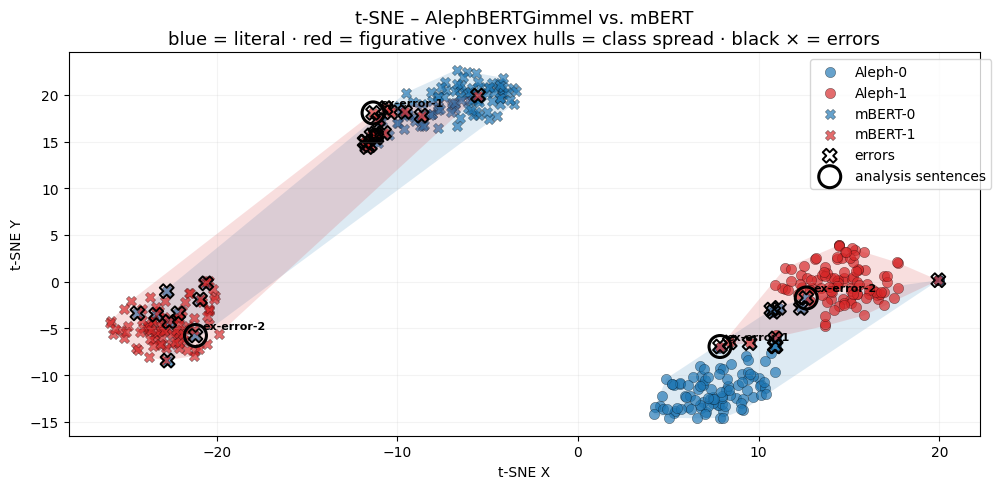

In [48]:
# ════════════════════════════════════════════════════════════════════════
# 6a  All points  (with hull note + sentence highlights)
# ════════════════════════════════════════════════════════════════════════

# --- sentences we want to flag -----------------------------------------
focus_sents = {
    "כולם הרימו ידיים כאות תמיכה במחאה נגד רשויות השלטון.": "ex-error-2",
    "המהנדס חתך פינה בתכנון והמבנה יצא לא יציב.":           "ex-error-1",
}

# tag the focus rows
df_tsne["focus"] = df_tsne["sentence"].map(focus_sents).fillna("")

def make_plot(df_plot, title, add_focus=False):
    plt.figure(figsize=(10,5)); ax = plt.gca()

    for (mdl, lab), grp in df_plot.groupby(["model","gold"]):
        sns.scatterplot(
            data      = grp, x="x", y="y",
            color     = palette_lbl[lab],
            marker    = marker_model[mdl],
            edgecolor = "black", linewidth=.3,
            alpha     = .68, s=55, label=f"{mdl}-{lab}", ax=ax
        )
        draw_hull(ax, grp.x, grp.y, palette_lbl[lab])

    # errors – big black X
    err = df_plot[~df_plot.correct]
    ax.scatter(err.x, err.y, s=100, marker="X", facecolors="none",
               edgecolors="black", linewidths=1.4, label="errors")

    # overlay focus sentences
    if add_focus:
        foc = df_plot[df_plot.focus != ""]
        ax.scatter(foc.x, foc.y,
                   s=250, marker="o", facecolors="none",
                   edgecolors="black", linewidths=2.2, zorder=5,
                   label="analysis sentences")
        # optional: annotate
        for _, r in foc.iterrows():
            ax.annotate(r.focus, (r.x, r.y),
                        textcoords="offset points", xytext=(5,5),
                        fontsize=8, weight="bold")

    ax.set_title(title, fontsize=13)
    ax.set_xlabel("t-SNE X"); ax.set_ylabel("t-SNE Y")
    ax.grid(alpha=.15)
    plt.tight_layout()
    ax.legend(bbox_to_anchor=(1.02,1))

# updated overall plot
make_plot(
    df_tsne,
    "t-SNE – AlephBERTGimmel vs. mBERT\n"
    "blue = literal · red = figurative · convex hulls = class spread · black × = errors",
    add_focus=True,
)

## Significance Testing AlephBERTGimmel and DictaBERT

In [42]:
ALEPH_DIR = Path("AlephBERTGimmel_idiom_full")/ "best"   # already trained best checkpoint dir
DICTA_DIR = Path("DictaBERT_idiom_full") / "best"         # update this if your folder name differs

# ============================
# Helper: tokenize a split with a specific tokenizer
# ============================
def build_tokenised_split(raw_datasets, tok):
    def tokenize_function(examples):
        return tok(examples["sentence"], truncation=True, max_length=64)

    tokenised = raw_datasets.map(
        tokenize_function,
        batched=True,
        remove_columns=["sentence", "expression"],   # matches your previous pipeline
    )
    tokenised.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return tokenised, DataCollatorWithPadding(tok)

# ============================
# Evaluate a single model on the test split
# ============================
def eval_model_on_test(model_dir, raw_datasets):
    tok = AutoTokenizer.from_pretrained(str(model_dir))
    tokenised, data_collator = build_tokenised_split(raw_datasets, tok)

    model = AutoModelForSequenceClassification.from_pretrained(str(model_dir)).to(device).eval()
    tr = Trainer(
        model=model,
        args=TrainingArguments(output_dir="/tmp/eval", do_train=False, report_to=[]),
        tokenizer=tok,
        data_collator=data_collator
    )

    test_out = tr.predict(tokenised["test"])
    logits    = test_out.predictions
    labels    = test_out.label_ids
    preds     = np.argmax(logits, axis=-1)
    probs_pos = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

    return {
        "labels": labels,
        "preds": preds,
        "probs_pos": probs_pos,
        "metrics": test_out.metrics
    }


#### AlephBERTGimmel plotting

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

/tmp/ipykernel_93/452901768.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(


AlephBERTGimmel test metrics: {'test_loss': 0.2298315465450287, 'test_model_preparation_time': 0.0026, 'test_runtime': 0.235, 'test_samples_per_second': 893.729, 'test_steps_per_second': 114.908}
              precision    recall  f1-score   support

     literal       0.95      0.93      0.94       105
  figurative       0.93      0.95      0.94       105

    accuracy                           0.94       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.94      0.94       210



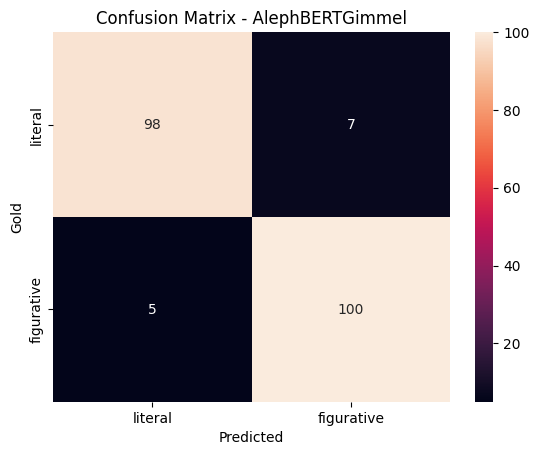

In [43]:
# ============================
# 1) AlephBERTGimmel
# ============================
aleph_out = eval_model_on_test(ALEPH_DIR, raw_datasets)
labels = aleph_out["labels"]  # ground truth

print("AlephBERTGimmel test metrics:", aleph_out["metrics"])
print(classification_report(labels, aleph_out["preds"], target_names=["literal", "figurative"]))
cm_aleph = confusion_matrix(labels, aleph_out["preds"])
sns.heatmap(cm_aleph, annot=True, fmt="d",
            xticklabels=["literal", "figurative"],
            yticklabels=["literal", "figurative"])
plt.ylabel("Gold")
plt.xlabel("Predicted")
plt.title("Confusion Matrix - AlephBERTGimmel")
plt.show()


#### DictaBERT plotting

Map:   0%|          | 0/810 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

/tmp/ipykernel_93/452901768.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tr = Trainer(


DictaBERT test metrics: {'test_loss': 0.15471979975700378, 'test_model_preparation_time': 0.0027, 'test_runtime': 0.2363, 'test_samples_per_second': 888.798, 'test_steps_per_second': 114.274}
              precision    recall  f1-score   support

     literal       0.96      0.96      0.96       105
  figurative       0.96      0.96      0.96       105

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



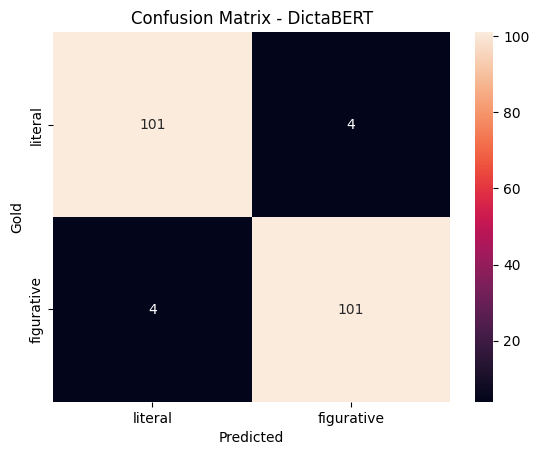

In [44]:
# ============================
# 2) DictaBERT
# ============================
dicta_out = eval_model_on_test(DICTA_DIR, raw_datasets)
assert np.array_equal(labels, dicta_out["labels"]), "Labels mismatch, splits must be identical"

print("DictaBERT test metrics:", dicta_out["metrics"])
print(classification_report(labels, dicta_out["preds"], target_names=["literal", "figurative"]))
cm_dicta = confusion_matrix(labels, dicta_out["preds"])
sns.heatmap(cm_dicta, annot=True, fmt="d",
            xticklabels=["literal", "figurative"],
            yticklabels=["literal", "figurative"])
plt.ylabel("Gold")
plt.xlabel("Predicted")
plt.title("Confusion Matrix - DictaBERT")
plt.show()


#### Statistical significance testing comparing both models

In [45]:
# ============================
# 3) McNemar's test (paired significance on the same test items)
# ============================
# Build correctness vectors
correct_aleph = (aleph_out["preds"] == labels)
correct_dicta = (dicta_out["preds"] == labels)

# Off-diagonal counts for McNemar
# b = Aleph wrong, Dicta right
# c = Aleph right, Dicta wrong
b = int(np.sum((~correct_aleph) & (correct_dicta)))
c = int(np.sum((correct_aleph) & (~correct_dicta)))

# Also compute diagonal counts for clarity
nn = int(np.sum((~correct_aleph) & (~correct_dicta)))
pp = int(np.sum(correct_aleph & correct_dicta))

contingency = np.array([[pp, c],
                        [b, nn]], dtype=int)

n = contingency.sum()
print("\nMcNemar contingency table (rows=Aleph correct/incorrect, cols=Dicta correct/incorrect):")
print("            Dicta correct   Dicta incorrect")
print(f"Aleph correct      {pp:4d}              {c:4d}")
print(f"Aleph incorrect    {b:4d}              {nn:4d}")
print(f"Total samples      {n}")

# Continuity corrected chi-square (approximate)
if HAVE_STATSMODELS:
    res = mcnemar(contingency, exact=False, correction=True)
    print(f"\nMcNemar chi-square (continuity corrected): statistic={res.statistic:.4f}, p-value={res.pvalue:.6f}")
else:
    print("\nstatsmodels not available, skipping chi-square approximation")

# Exact binomial test on the off-diagonals
# Null: b == c with p=0.5. Test is two-sided.
off = b + c
if off > 0:
    exact = binomtest(k=min(b, c), n=off, p=0.5, alternative="two-sided")
    print(f"McNemar exact binomial: off-diagonals b={b}, c={c}, n_off={off}, p-value={exact.pvalue:.6f}")
else:
    print("McNemar exact binomial: off-diagonals are zero, models made identical decisions on every item")

# Quick interpretation
def interpret(b, c, alpha=0.05):
    if b + c == 0:
        return "Models are tied on every item"
    direction = "AlephBERTGimmel better" if c > b else ("DictaBERT better" if b > c else "No directional difference")
    return f"Direction by raw counts: {direction} (c - b = {c - b})"

print("\nInterpretation:", interpret(b, c))


McNemar contingency table (rows=Aleph correct/incorrect, cols=Dicta correct/incorrect):
            Dicta correct   Dicta incorrect
Aleph correct       196                 2
Aleph incorrect       6                 6
Total samples      210

statsmodels not available, skipping chi-square approximation
McNemar exact binomial: off-diagonals b=6, c=2, n_off=8, p-value=0.289062

Interpretation: Direction by raw counts: DictaBERT better (c - b = -4)


## Training with k-folds

In [46]:
# -------------------------
# Paths and model choice
# -------------------------
CSV_PATH = Path("data/expressions_data.csv")

# Choose a model id or a local folder with a pretrained checkpoint
# MODEL_ID = "/content/drive/MyDrive/Final_NLP_DATA/AlephBERTGimmel"  # local folder
MODEL_ID = "dicta-il/alephbertgimmel-base"   # start from fresh base weights on HF

RUN_ROOT = Path("./cv_runs")     # all folds live here
RUN_ROOT.mkdir(parents=True, exist_ok=True)


#### Data Preperation

In [47]:
# -------------------------
# 1) Load CSV and sanity checks (mirrors your script)
# -------------------------
keep_cols = ["expression", "sentence", "label", "label_2"]
df = pd.read_csv(CSV_PATH, usecols=lambda c: c in keep_cols)

expected_cols = {"expression", "sentence", "label", "label_2"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

print("Raw dataset shape:", df.shape)
print("Label distribution (label):\n", df["label"].value_counts(dropna=False))


Raw dataset shape: (1230, 4)
Label distribution (label):
 label
פיגורטיבי    615
מילולי       615
Name: count, dtype: int64


In [48]:
# -------------------------
# 2) Cleaning (same spirit as your pipeline)
# -------------------------
df = df.drop_duplicates(subset=["sentence"])
df = df.dropna(subset=["sentence"]).reset_index(drop=True)

def clean_text(txt: str) -> str:
    txt = re.sub(r"\s+", " ", str(txt)).strip()
    txt = re.sub(r"[!?]{3,}", "!", txt)
    txt = txt.replace("׳", "'")
    return txt

df["sentence"] = df["sentence"].apply(clean_text)
df = df[df["sentence"].str.split().str.len() >= 4]
df = df.drop_duplicates(subset=["sentence", "label"]).reset_index(drop=True)

# Keep only label_2 as the canonical label
if "label" in df.columns:
    df = df.drop(columns=["label"])
df = df.rename(columns={"label_2": "labels"})

# Enforce dtypes
df["sentence"] = df["sentence"].astype(str)
df["expression"] = df["expression"].astype(str)
df["labels"] = df["labels"].astype(int)

print("After cleaning:", df.shape)
print("Label distribution (labels):\n", df["labels"].value_counts())


After cleaning: (1230, 3)
Label distribution (labels):
 labels
1    615
0    615
Name: count, dtype: int64


#### K-folds preperation

In [49]:
# -------------------------
# 3) CV setup: GroupKFold on expressions
# -------------------------
K = 10                      # change to 10 if you prefer
VAL_FRACTION = 0.15        # carved from the training portion using grouped split

groups = df["expression"].values
gkf = GroupKFold(n_splits=K)

# Metrics to collect across folds
fold_summaries = []
all_test_preds = []
agg_cm = np.zeros((2, 2), dtype=int)

# Shared metrics for the Trainer
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1":       f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


In [50]:
# -------------------------
# Helper to build HF datasets for any pandas splits
# -------------------------
def to_hf(train_df, val_df, test_df):
    ds = datasets.DatasetDict({
        "train": datasets.Dataset.from_pandas(train_df, preserve_index=False),
        "validation": datasets.Dataset.from_pandas(val_df, preserve_index=False),
        "test": datasets.Dataset.from_pandas(test_df, preserve_index=False),
    })
    return ds

#### Training for all k-folds

In [51]:
# -------------------------
# Fold loop
# -------------------------
fold_id = 0
for train_val_idx, test_idx in gkf.split(df, groups=groups):
    fold_id += 1
    print(f"\n========== Fold {fold_id}/{K} ==========")

    df_train_val = df.iloc[train_val_idx].reset_index(drop=True)
    df_test      = df.iloc[test_idx].reset_index(drop=True)

    # Carve a grouped validation from train_val
    gss_val = GroupShuffleSplit(test_size=VAL_FRACTION, n_splits=1, random_state=SEED)
    tv_idx, val_idx = next(gss_val.split(df_train_val, groups=df_train_val["expression"]))
    df_train = df_train_val.iloc[tv_idx].reset_index(drop=True)
    df_val   = df_train_val.iloc[val_idx].reset_index(drop=True)

    # Leakage checks on expressions
    train_expr = set(df_train["expression"].unique())
    val_expr   = set(df_val["expression"].unique())
    test_expr  = set(df_test["expression"].unique())
    assert train_expr.isdisjoint(val_expr)
    assert train_expr.isdisjoint(test_expr)
    assert val_expr.isdisjoint(test_expr)

    # Build HF datasets
    dsd = to_hf(df_train, df_val, df_test)

    # Tokenizer and collator per fold to avoid caching surprises
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    def tok_fn(examples):
        return tokenizer(examples["sentence"], truncation=True, max_length=64)

    tokenised = dsd.map(
        tok_fn,
        batched=True,
        remove_columns=["sentence", "expression"],   # drop raw fields
        desc=f"Tokenising Fold {fold_id}"
    )
    tokenised.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    data_collator = DataCollatorWithPadding(tokenizer)

    # Model and training setup
    fold_dir = RUN_ROOT / f"fold_{fold_id}"
    LOG_DIR  = fold_dir / "logs"
    BEST_DIR = fold_dir / "best"
    fold_dir.mkdir(parents=True, exist_ok=True)
    LOG_DIR.mkdir(parents=True, exist_ok=True)
    BEST_DIR.mkdir(parents=True, exist_ok=True)

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_ID, num_labels=2, low_cpu_mem_usage=True
    ).to(device)
    model.gradient_checkpointing_enable()

    training_args = TrainingArguments(
        output_dir              = fold_dir.as_posix(),
        eval_strategy     = "epoch",
        save_strategy           = "epoch",
        save_total_limit        = 1,
        load_best_model_at_end  = True,
        save_only_model         = True,
        metric_for_best_model   = "eval_f1",
        greater_is_better       = True,
        logging_dir             = LOG_DIR.as_posix(),
        logging_strategy        = "steps",
        logging_steps           = 20,
        # your best params
        learning_rate           = 5e-5,        # LR
        num_train_epochs        = 8,           # epochs
        weight_decay            = 0.0,         # weight decay
        warmup_ratio            = 0.2249,      # warmup steps percent
        lr_scheduler_type       = "linear",    # scheduler
        label_smoothing_factor  = 0.10,        # label smoothing

        # batch sizes
        per_device_train_batch_size = 8,       # was 1
        per_device_eval_batch_size  = 16,      # safe and faster
        gradient_accumulation_steps = 1,       # disable accumulation

        fp16=False, bf16=False,
        seed=SEED,
        report_to=["tensorboard"],
        dataloader_pin_memory=False
    )

    trainer = Trainer(
        model           = model,
        args            = training_args,
        train_dataset   = tokenised["train"],
        eval_dataset    = tokenised["validation"],
        tokenizer       = tokenizer,
        data_collator   = data_collator,
        compute_metrics = compute_metrics,
        callbacks       = [EarlyStoppingCallback(early_stopping_patience=2)]
    )

    train_out = trainer.train()
    # Save best weights for the fold
    model.save_pretrained(BEST_DIR)
    tokenizer.save_pretrained(BEST_DIR)

    # Keep training history
    with open(fold_dir / "history.json", "w", encoding="utf8") as fh:
        json.dump(trainer.state.log_history, fh, indent=2, ensure_ascii=False)

    # Validation metrics at the best checkpoint
    val_metrics = trainer.evaluate(eval_dataset=tokenised["validation"])
    print("Fold", fold_id, "validation:", val_metrics)

    # Test predictions at the best checkpoint
    test_out = trainer.predict(test_dataset=tokenised["test"])
    logits_test = test_out.predictions
    y_test = test_out.label_ids
    y_pred = np.argmax(logits_test, axis=-1)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")
    print("Fold", fold_id, "test accuracy:", acc, "test macro-F1:", f1)
    print(classification_report(y_test, y_pred, target_names=["literal", "figurative"]))

    # Confusion matrix aggregation
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    agg_cm += cm

    # Save per fold predictions
    fold_preds = pd.DataFrame({
        "fold": fold_id,
        "expression": df_test["expression"].values,
        "sentence": df_test["sentence"].values,
        "label": y_test,
        "pred": y_pred
    })
    fold_preds.to_csv(fold_dir / "test_predictions.csv", index=False)

    # Log summary for the fold
    summary = {
        "fold": fold_id,
        "n_train": len(df_train),
        "n_val": len(df_val),
        "n_test": len(df_test),
        "val_accuracy": float(val_metrics.get("eval_accuracy", np.nan)),
        "val_f1": float(val_metrics.get("eval_f1", np.nan)),
        "test_accuracy": float(acc),
        "test_macro_f1": float(f1),
    }
    with open(fold_dir / "summary.json", "w") as f:
        json.dump(summary, f, indent=2)
    fold_summaries.append(summary)

    # Memory hygiene between folds
    del trainer, model, tokenised, dsd, logits_test, y_test, y_pred
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()



========== Fold 1/10 ==========


Tokenising Fold 1:   0%|          | 0/900 [00:00<?, ? examples/s]

Tokenising Fold 1:   0%|          | 0/180 [00:00<?, ? examples/s]

Tokenising Fold 1:   0%|          | 0/150 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_93/1400602800.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Exception ignored in: <function BaseFileLock.__del__ at 0x7fef0aff2ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/filelock/_api.py", line 397, in __del__
    self.release(force=True)
  File "/opt/conda/lib/python3.11/site-packages/filelock/_api.py", line 358, in release
    if self.is_locked:
       ^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/filelock/_api.py", line 264, in is_locked
    return self._context.lock_file_fd is not None
       

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.585100,0.586640,0.733333,0.723467
2,0.313300,0.396597,0.916667,0.916458
3,0.319900,0.431421,0.900000,0.899554
4,0.240000,0.528204,0.855556,0.853750


Fold 1 validation: {'eval_loss': 0.39659708738327026, 'eval_accuracy': 0.9166666666666666, 'eval_f1': 0.9164578111946533, 'eval_runtime': 0.1358, 'eval_samples_per_second': 1325.131, 'eval_steps_per_second': 88.342, 'epoch': 4.0}
Fold 1 test accuracy: 0.9066666666666666 test macro-F1: 0.9058464849354376
              precision    recall  f1-score   support

     literal       0.84      1.00      0.91        75
  figurative       1.00      0.81      0.90        75

    accuracy                           0.91       150
   macro avg       0.92      0.91      0.91       150
weighted avg       0.92      0.91      0.91       150


========== Fold 2/10 ==========


Tokenising Fold 2:   0%|          | 0/930 [00:00<?, ? examples/s]

Tokenising Fold 2:   0%|          | 0/180 [00:00<?, ? examples/s]

Tokenising Fold 2:   0%|          | 0/120 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_93/1400602800.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.611800,0.494724,0.911111,0.910570
2,0.405700,0.346832,0.938889,0.938736
3,0.241300,0.302622,0.955556,0.955506
4,0.250100,0.313644,0.950000,0.949924
5,0.203100,0.343594,0.944444,0.944334


Fold 2 validation: {'eval_loss': 0.30262234807014465, 'eval_accuracy': 0.9555555555555556, 'eval_f1': 0.9555061179087876, 'eval_runtime': 0.1614, 'eval_samples_per_second': 1115.236, 'eval_steps_per_second': 74.349, 'epoch': 5.0}
Fold 2 test accuracy: 0.9416666666666667 test macro-F1: 0.9416301855326246
              precision    recall  f1-score   support

     literal       0.96      0.92      0.94        60
  figurative       0.92      0.97      0.94        60

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120


========== Fold 3/10 ==========


Tokenising Fold 3:   0%|          | 0/930 [00:00<?, ? examples/s]

Tokenising Fold 3:   0%|          | 0/180 [00:00<?, ? examples/s]

Tokenising Fold 3:   0%|          | 0/120 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_93/1400602800.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.640000,0.497101,0.911111,0.910836
2,0.314500,0.474251,0.861111,0.858806
3,0.255900,0.230923,0.983333,0.983333
4,0.251400,0.241202,0.983333,0.983333
5,0.211700,0.254278,0.972222,0.972215


Fold 3 validation: {'eval_loss': 0.23092308640480042, 'eval_accuracy': 0.9833333333333333, 'eval_f1': 0.983332818914164, 'eval_runtime': 0.1367, 'eval_samples_per_second': 1316.861, 'eval_steps_per_second': 87.791, 'epoch': 5.0}
Fold 3 test accuracy: 0.875 test macro-F1: 0.8745732004738346
              precision    recall  f1-score   support

     literal       0.84      0.93      0.88        60
  figurative       0.92      0.82      0.87        60

    accuracy                           0.88       120
   macro avg       0.88      0.88      0.87       120
weighted avg       0.88      0.88      0.87       120


========== Fold 4/10 ==========


Tokenising Fold 4:   0%|          | 0/930 [00:00<?, ? examples/s]

Tokenising Fold 4:   0%|          | 0/180 [00:00<?, ? examples/s]

Tokenising Fold 4:   0%|          | 0/120 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_93/1400602800.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.682100,0.493576,0.905556,0.905413
2,0.363600,0.397591,0.900000,0.898990
3,0.236800,0.280019,0.966667,0.966630
4,0.243500,0.306891,0.950000,0.949875
5,0.200300,0.336098,0.950000,0.949924


Fold 4 validation: {'eval_loss': 0.280019074678421, 'eval_accuracy': 0.9666666666666667, 'eval_f1': 0.9666295884315907, 'eval_runtime': 0.1359, 'eval_samples_per_second': 1324.101, 'eval_steps_per_second': 88.273, 'epoch': 5.0}
Fold 4 test accuracy: 0.9666666666666667 test macro-F1: 0.9666574048346763
              precision    recall  f1-score   support

     literal       0.95      0.98      0.97        60
  figurative       0.98      0.95      0.97        60

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120


========== Fold 5/10 ==========


Tokenising Fold 5:   0%|          | 0/930 [00:00<?, ? examples/s]

Tokenising Fold 5:   0%|          | 0/180 [00:00<?, ? examples/s]

Tokenising Fold 5:   0%|          | 0/120 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_93/1400602800.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.641500,0.623484,0.844444,0.844137
2,0.382100,0.716584,0.583333,0.495798
3,0.218000,0.244169,0.983333,0.983333
4,0.298700,0.271466,0.966667,0.966667
5,0.273200,0.287886,0.955556,0.955550


Fold 5 validation: {'eval_loss': 0.2441686987876892, 'eval_accuracy': 0.9833333333333333, 'eval_f1': 0.983332818914164, 'eval_runtime': 0.1369, 'eval_samples_per_second': 1314.774, 'eval_steps_per_second': 87.652, 'epoch': 5.0}
Fold 5 test accuracy: 0.9416666666666667 test macro-F1: 0.9416301855326246
              precision    recall  f1-score   support

     literal       0.96      0.92      0.94        60
  figurative       0.92      0.97      0.94        60

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120


========== Fold 6/10 ==========


Tokenising Fold 6:   0%|          | 0/930 [00:00<?, ? examples/s]

Tokenising Fold 6:   0%|          | 0/180 [00:00<?, ? examples/s]

Tokenising Fold 6:   0%|          | 0/120 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_93/1400602800.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.626200,0.464109,0.877778,0.877399
2,0.332800,0.286744,0.966667,0.966650
3,0.297400,0.257831,0.966667,0.966663
4,0.223300,0.306893,0.950000,0.949924
5,0.203700,0.269319,0.972222,0.972221
6,0.216600,0.271043,0.966667,0.966630
7,0.264000,0.284850,0.961111,0.961052


Fold 6 validation: {'eval_loss': 0.26931896805763245, 'eval_accuracy': 0.9722222222222222, 'eval_f1': 0.97222136485694, 'eval_runtime': 0.1358, 'eval_samples_per_second': 1325.81, 'eval_steps_per_second': 88.387, 'epoch': 7.0}
Fold 6 test accuracy: 0.975 test macro-F1: 0.9749843652282677
              precision    recall  f1-score   support

     literal       1.00      0.95      0.97        60
  figurative       0.95      1.00      0.98        60

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120


========== Fold 7/10 ==========


Tokenising Fold 7:   0%|          | 0/930 [00:00<?, ? examples/s]

Tokenising Fold 7:   0%|          | 0/180 [00:00<?, ? examples/s]

Tokenising Fold 7:   0%|          | 0/120 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_93/1400602800.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.660000,0.567944,0.783333,0.780344
2,0.331300,0.342043,0.911111,0.910570
3,0.222300,0.294844,0.955556,0.955468
4,0.238300,0.308741,0.955556,0.955468
5,0.200100,0.271617,0.966667,0.966630
6,0.220100,0.301834,0.961111,0.961052
7,0.200100,0.285181,0.966667,0.966630


Fold 7 validation: {'eval_loss': 0.2716171145439148, 'eval_accuracy': 0.9666666666666667, 'eval_f1': 0.9666295884315907, 'eval_runtime': 0.1364, 'eval_samples_per_second': 1319.784, 'eval_steps_per_second': 87.986, 'epoch': 7.0}
Fold 7 test accuracy: 0.8833333333333333 test macro-F1: 0.8830409356725146
              precision    recall  f1-score   support

     literal       0.93      0.83      0.88        60
  figurative       0.85      0.93      0.89        60

    accuracy                           0.88       120
   macro avg       0.89      0.88      0.88       120
weighted avg       0.89      0.88      0.88       120


========== Fold 8/10 ==========


Tokenising Fold 8:   0%|          | 0/930 [00:00<?, ? examples/s]

Tokenising Fold 8:   0%|          | 0/180 [00:00<?, ? examples/s]

Tokenising Fold 8:   0%|          | 0/120 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_93/1400602800.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.679100,0.520686,0.883333,0.883041
2,0.381600,0.598952,0.738889,0.719784
3,0.381200,0.265198,0.972222,0.972221
4,0.290500,0.307578,0.938889,0.938842
5,0.213700,0.307732,0.950000,0.949986


Fold 8 validation: {'eval_loss': 0.2651984691619873, 'eval_accuracy': 0.9722222222222222, 'eval_f1': 0.97222136485694, 'eval_runtime': 0.1365, 'eval_samples_per_second': 1318.335, 'eval_steps_per_second': 87.889, 'epoch': 5.0}
Fold 8 test accuracy: 0.95 test macro-F1: 0.949944382647386
              precision    recall  f1-score   support

     literal       0.98      0.92      0.95        60
  figurative       0.92      0.98      0.95        60

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120


========== Fold 9/10 ==========


Tokenising Fold 9:   0%|          | 0/930 [00:00<?, ? examples/s]

Tokenising Fold 9:   0%|          | 0/180 [00:00<?, ? examples/s]

Tokenising Fold 9:   0%|          | 0/120 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_93/1400602800.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.512500,0.503672,0.811111,0.806427
2,0.292500,0.302674,0.955556,0.955534
3,0.241500,0.277962,0.955556,0.955534
4,0.201000,0.263372,0.972222,0.972221
5,0.200900,0.268083,0.966667,0.966667
6,0.216900,0.315078,0.950000,0.949875


Fold 9 validation: {'eval_loss': 0.2633722424507141, 'eval_accuracy': 0.9722222222222222, 'eval_f1': 0.97222136485694, 'eval_runtime': 0.1351, 'eval_samples_per_second': 1332.355, 'eval_steps_per_second': 88.824, 'epoch': 6.0}
Fold 9 test accuracy: 0.8666666666666667 test macro-F1: 0.8648268093494791
              precision    recall  f1-score   support

     literal       0.98      0.75      0.85        60
  figurative       0.80      0.98      0.88        60

    accuracy                           0.87       120
   macro avg       0.89      0.87      0.86       120
weighted avg       0.89      0.87      0.86       120


========== Fold 10/10 ==========


Tokenising Fold 10:   0%|          | 0/930 [00:00<?, ? examples/s]

Tokenising Fold 10:   0%|          | 0/180 [00:00<?, ? examples/s]

Tokenising Fold 10:   0%|          | 0/120 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_93/1400602800.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.627800,0.459380,0.883333,0.883157
2,0.425000,0.287868,0.944444,0.944383
3,0.413400,0.239640,0.983333,0.983333
4,0.252900,0.306987,0.950000,0.949924
5,0.214800,0.247325,0.977778,0.977775


Fold 10 validation: {'eval_loss': 0.239640474319458, 'eval_accuracy': 0.9833333333333333, 'eval_f1': 0.983332818914164, 'eval_runtime': 0.1363, 'eval_samples_per_second': 1320.814, 'eval_steps_per_second': 88.054, 'epoch': 5.0}
Fold 10 test accuracy: 0.9416666666666667 test macro-F1: 0.9414674935544561
              precision    recall  f1-score   support

     literal       0.90      1.00      0.94        60
  figurative       1.00      0.88      0.94        60

    accuracy                           0.94       120
   macro avg       0.95      0.94      0.94       120
weighted avg       0.95      0.94      0.94       120



In [52]:
# -------------------------
# 4) Aggregate across folds
# -------------------------
sum_df = pd.DataFrame(fold_summaries)
print("\nPer fold summary:\n", sum_df)

def mean_std(col):
    return float(sum_df[col].mean()), float(sum_df[col].std(ddof=1)) if len(sum_df) > 1 else (float(sum_df[col].mean()), 0.0)

acc_mean, acc_std = mean_std("test_accuracy")
f1_mean, f1_std   = mean_std("test_macro_f1")

print(f"\nCross-validated test accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
print(f"Cross-validated test macro-F1: {f1_mean:.4f} ± {f1_std:.4f}")
print("\nAggregated confusion matrix across folds (rows gold, cols pred):\n", agg_cm)

# Save global summary
global_summary = {
    "model_id": MODEL_ID,
    "k_folds": K,
    "val_fraction_within_train": VAL_FRACTION,
    "cv_test_accuracy_mean": acc_mean,
    "cv_test_accuracy_std": acc_std,
    "cv_test_macro_f1_mean": f1_mean,
    "cv_test_macro_f1_std": f1_std,
    "aggregated_confusion_matrix": agg_cm.tolist()
}
with open(RUN_ROOT / "cv_summary.json", "w") as f:
    json.dump(global_summary, f, indent=2)

sum_df.to_csv(RUN_ROOT / "cv_fold_metrics.csv", index=False)
print("\nArtifacts saved under:", RUN_ROOT.resolve())


Per fold summary:
    fold  n_train  n_val  n_test  val_accuracy    val_f1  test_accuracy  \
0     1      900    180     150      0.916667  0.916458       0.906667   
1     2      930    180     120      0.955556  0.955506       0.941667   
2     3      930    180     120      0.983333  0.983333       0.875000   
3     4      930    180     120      0.966667  0.966630       0.966667   
4     5      930    180     120      0.983333  0.983333       0.941667   
5     6      930    180     120      0.972222  0.972221       0.975000   
6     7      930    180     120      0.966667  0.966630       0.883333   
7     8      930    180     120      0.972222  0.972221       0.950000   
8     9      930    180     120      0.972222  0.972221       0.866667   
9    10      930    180     120      0.983333  0.983333       0.941667   

   test_macro_f1  
0       0.905846  
1       0.941630  
2       0.874573  
3       0.966657  
4       0.941630  
5       0.974984  
6       0.883041  
7       0.949